In [1]:
# Data handling and utilities
import pandas as pd
import numpy as np
from pathlib import Path
from functools import reduce
from collections import OrderedDict
import re
import utils

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams

# Set configurations for visualization
%config InlineBackend.figure_formats = {'retina', 'svg'}
%matplotlib inline
rcParams['figure.figsize'] = (8, 6)
sns.set(style='ticks', palette="Paired", font_scale=0.8)

# Signal processing
from scipy import signal
from scipy.signal import find_peaks

# Machine learning and metrics
from sklearn.model_selection import train_test_split, cross_validate, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error,
    mean_absolute_percentage_error, median_absolute_error, 
    r2_score, explained_variance_score
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

# Toolz for functional programming
from toolz.itertoolz import partial

OMP: Warning #182: OMP_STACKSIZE: ignored because KMP_STACKSIZE has been defined
OMP: Warning #182: GOMP_STACKSIZE: ignored because KMP_STACKSIZE has been defined


# import data

In [16]:
file_path = 'data/dataset.csv'

df = pd.read_csv(file_path)
target = 'flow_rate'


X, y = df.drop(columns=target), df[target]
X.columns = X.columns.astype(float)

X.columns.name = 'freq'

In [17]:
df

flow_rate         0      0.25       0.5      0.75         1      1.25  \
0    49.706452  0.005792  0.017376  0.005792  0.002896  0.000724  0.001448   
1    52.454839  0.005068  0.014842  0.005792  0.001448  0.001086  0.000724   
2    55.087097  0.005792  0.017376  0.005792  0.002172  0.000724  0.001448   
3    57.496774  0.006154  0.018462  0.006878  0.002534  0.001448  0.000724   
4    60.190323  0.007964  0.019549  0.007240  0.002172  0.000724  0.000000   
..         ...       ...       ...       ...       ...       ...       ...   
95  287.367742  0.007240  0.019911  0.007240  0.002896  0.001810  0.000724   
96  290.287097  0.008688  0.022083  0.008326  0.003620  0.001448  0.001448   
97  292.832258  0.006878  0.019911  0.006878  0.003620  0.001448  0.001086   
98  295.116129  0.006516  0.018100  0.006878  0.002534  0.001086  0.001086   
99  297.706452  0.006516  0.018100  0.006878  0.002534  0.001086  0.001086   

         1.5      1.75         2  ...     797.5    797.75       798    798.25  \
0   0.000000  0.000000  0.000000  ...  0.005068  0.006516  0.002172  0.004344   
1   0.000362  0.001448  0.000362  ...  0.003258  0.004706  0.006516  0.005430   
2   0.000000  0.000724  0.000000  ...  0.001448  0.000724  0.000724  0.003620   
3   0.000724  0.000000  0.000724  ...  0.005792  0.003258  0.002172  0.004706   
4   0.000000  0.000724  0.000000  ...  0.005068  0.005792  0.005068  0.005068   
..       ...       ...       ...  ...       ...       ...       ...       ...   
95  0.000362  0.000000  0.000724  ...  0.001086  0.002534  0.003982  0.002534   
96  0.001086  0.000362  0.000362  ...  0.001810  0.001086  0.001086  0.003620   
97  0.000000  0.000362  0.000724  ...  0.001810  0.001086  0.001086  0.001086   
98  0.000000  0.001086  0.000362  ...  0.001086  0.000362  0.001086  0.002534   
99  0.000000  0.001086  0.000362  ...  0.001086  0.000362  0.001086  0.002534   

       798.5    798.75       799    799.25     799.5    799.75  
0   0.003620  0.001448  0.002172  0.007240  0.004344  0.010136  
1   0.004344  0.002172  0.003620  0.009050  0.006516  0.007964  
2   0.006516  0.003620  0.004344  0.008688  0.007964  0.011584  
3   0.004706  0.001810  0.002534  0.008688  0.006878  0.006154  
4   0.002172  0.001448  0.002172  0.008688  0.010860  0.007964  
..       ...       ...       ...       ...       ...       ...  
95  0.001448  0.003982  0.007240  0.007964  0.010136  0.004706  
96  0.004344  0.002896  0.007964  0.009050  0.010860  0.005430  
97  0.004706  0.006154  0.009412  0.007602  0.008326  0.002534  
98  0.006154  0.007602  0.009050  0.013032  0.015566  0.005068  
99  0.006154  0.007602  0.009050  0.013032  0.015566  0.005068  

[100 rows x 3201 columns]

In [18]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0
)

X

freq    0.00      0.25      0.50      0.75      1.00      1.25      1.50    \
0     0.005792  0.017376  0.005792  0.002896  0.000724  0.001448  0.000000   
1     0.005068  0.014842  0.005792  0.001448  0.001086  0.000724  0.000362   
2     0.005792  0.017376  0.005792  0.002172  0.000724  0.001448  0.000000   
3     0.006154  0.018462  0.006878  0.002534  0.001448  0.000724  0.000724   
4     0.007964  0.019549  0.007240  0.002172  0.000724  0.000000  0.000000   
..         ...       ...       ...       ...       ...       ...       ...   
95    0.007240  0.019911  0.007240  0.002896  0.001810  0.000724  0.000362   
96    0.008688  0.022083  0.008326  0.003620  0.001448  0.001448  0.001086   
97    0.006878  0.019911  0.006878  0.003620  0.001448  0.001086  0.000000   
98    0.006516  0.018100  0.006878  0.002534  0.001086  0.001086  0.000000   
99    0.006516  0.018100  0.006878  0.002534  0.001086  0.001086  0.000000   

freq    1.75      2.00      2.25    ...    797.50    797.75    798.00  \
0     0.000000  0.000000  0.000000  ...  0.005068  0.006516  0.002172   
1     0.001448  0.000362  0.001448  ...  0.003258  0.004706  0.006516   
2     0.000724  0.000000  0.000000  ...  0.001448  0.000724  0.000724   
3     0.000000  0.000724  0.001448  ...  0.005792  0.003258  0.002172   
4     0.000724  0.000000  0.000724  ...  0.005068  0.005792  0.005068   
..         ...       ...       ...  ...       ...       ...       ...   
95    0.000000  0.000724  0.000724  ...  0.001086  0.002534  0.003982   
96    0.000362  0.000362  0.000724  ...  0.001810  0.001086  0.001086   
97    0.000362  0.000724  0.001448  ...  0.001810  0.001086  0.001086   
98    0.001086  0.000362  0.000000  ...  0.001086  0.000362  0.001086   
99    0.001086  0.000362  0.000000  ...  0.001086  0.000362  0.001086   

freq    798.25    798.50    798.75    799.00    799.25    799.50    799.75  
0     0.004344  0.003620  0.001448  0.002172  0.007240  0.004344  0.010136  
1     0.005430  0.004344  0.002172  0.003620  0.009050  0.006516  0.007964  
2     0.003620  0.006516  0.003620  0.004344  0.008688  0.007964  0.011584  
3     0.004706  0.004706  0.001810  0.002534  0.008688  0.006878  0.006154  
4     0.005068  0.002172  0.001448  0.002172  0.008688  0.010860  0.007964  
..         ...       ...       ...       ...       ...       ...       ...  
95    0.002534  0.001448  0.003982  0.007240  0.007964  0.010136  0.004706  
96    0.003620  0.004344  0.002896  0.007964  0.009050  0.010860  0.005430  
97    0.001086  0.004706  0.006154  0.009412  0.007602  0.008326  0.002534  
98    0.002534  0.006154  0.007602  0.009050  0.013032  0.015566  0.005068  
99    0.002534  0.006154  0.007602  0.009050  0.013032  0.015566  0.005068  

[100 rows x 3200 columns]

## view 

In [7]:
visualization = visualizationlibrary.Visualization(file_path)

visualization.raw_data_plot()

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

OMP: Warning #182: OMP_STACKSIZE: ignored because KMP_STACKSIZE has been defined
OMP: Warning #182: GOMP_STACKSIZE: ignored because KMP_STACKSIZE has been defined


:Surface   [x,y]   (z)

# Grid Search

In [8]:
'''
method
-----------
mean: mean
std: standard deviation
var: variance 
median: median


window
------------
hann: Hanning window function
gaussian: Gaussian window function, based on the Gaussian distribution
triang: Triangular window function, similar to a triangle shape
blackman: Blackman window function, with lower sidelobes
hamming: Hamming window function, similar to Blackman but with slower sidelobe attenuation
bartlett: Bartlett window function, similar to triangular but with a flatter top
kaiser: KaiserKaiser window function, with an adjustable shape parameter to control the main lobe width and sidelobe levels


max_no_peaks
------------
empirical value,
ranges from 25-45 

'''
 

param_space = {
    'method':['mean','std','median','var'],
    'window': ['hann','gaussian','triang','blackman','hamming','bartlett','kaiser'],
    'max_no_peaks': range(25, 46) # from 25 - 45
}


In [9]:
import time


Best_Parameters = {'method':None,'window': None, 'max_no_peaks':None}
Best_Score = 0

print('Start grid search, current time:', time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))


for method in param_space['method']:
    for window in param_space['window']:
        for max_no_peaks in param_space['max_no_peaks']:
            # Current parameter output
            print('Current parameters:', method, window, max_no_peaks)

            PF_feat_extr = pp.PFSpectraFeatExtr(
                agg_spectra_method=method,
                spectrum_window_size=60,
                agg_spectrum_window_size=60,
                max_no_peaks=max_no_peaks,  
                peaks_base_level=0.0025,
                fb_peak_freq_power_feat=True,
                fb_dist_shape_auc_feat=False,
                peak_freq_power_feat=False,
                dist_shape_auc_feat=True,
                signal_window=window
            )
            
            
            reg_pipe = Pipeline(
                steps=[
                    ('pp', PF_feat_extr),
                    ('reg', RandomForestRegressor(random_state=0))    
                ]
            )
            
            
            reg_pipe_fitted = reg_pipe.fit(X_train, y_train)
            
            
            
            test_results = pp.evaluate_metrics(reg_pipe_fitted, X_test, y_test)
            
            
            
            if test_results['r2']>Best_Score:
                Best_Score = test_results['r2']
                Best_Parameters['method'] = method
                Best_Parameters['window'] = window
                Best_Parameters['max_no_peaks'] = max_no_peaks
            
            
print('Best Parameters: ',Best_Parameters)
print('Best Score(r2): ',Best_Score)
print('End grid search, current time:', time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())))
            

Start grid search, current time: 2023-12-11 16:29:46
Current parameters: mean hann 25
Current parameters: mean hann 26
Current parameters: mean hann 27
Current parameters: mean hann 28
Current parameters: mean hann 29
Current parameters: mean hann 30
Current parameters: mean hann 31
Current parameters: mean hann 32
Current parameters: mean hann 33
Current parameters: mean hann 34
Current parameters: mean hann 35
Current parameters: mean hann 36
Current parameters: mean hann 37
Current parameters: mean hann 38
Current parameters: mean hann 39
Current parameters: mean hann 40
Current parameters: mean hann 41
Current parameters: mean hann 42
Current parameters: mean hann 43
Current parameters: mean hann 44
Current parameters: mean hann 45
Current parameters: mean gaussian 25
Current parameters: mean gaussian 26
Current parameters: mean gaussian 27
Current parameters: mean gaussian 28
Current parameters: mean gaussian 29
Current parameters: mean gaussian 30
Current parameters: mean gaussia

Current parameters: std hamming 25
Current parameters: std hamming 26
Current parameters: std hamming 27
Current parameters: std hamming 28
Current parameters: std hamming 29
Current parameters: std hamming 30
Current parameters: std hamming 31
Current parameters: std hamming 32
Current parameters: std hamming 33
Current parameters: std hamming 34
Current parameters: std hamming 35
Current parameters: std hamming 36
Current parameters: std hamming 37
Current parameters: std hamming 38
Current parameters: std hamming 39
Current parameters: std hamming 40
Current parameters: std hamming 41
Current parameters: std hamming 42
Current parameters: std hamming 43
Current parameters: std hamming 44
Current parameters: std hamming 45
Current parameters: std bartlett 25
Current parameters: std bartlett 26
Current parameters: std bartlett 27
Current parameters: std bartlett 28
Current parameters: std bartlett 29
Current parameters: std bartlett 30
Current parameters: std bartlett 31
Current param

Current parameters: var hann 39
Current parameters: var hann 40
Current parameters: var hann 41
Current parameters: var hann 42
Current parameters: var hann 43
Current parameters: var hann 44
Current parameters: var hann 45
Current parameters: var gaussian 25
Current parameters: var gaussian 26
Current parameters: var gaussian 27
Current parameters: var gaussian 28
Current parameters: var gaussian 29
Current parameters: var gaussian 30
Current parameters: var gaussian 31
Current parameters: var gaussian 32
Current parameters: var gaussian 33
Current parameters: var gaussian 34
Current parameters: var gaussian 35
Current parameters: var gaussian 36
Current parameters: var gaussian 37
Current parameters: var gaussian 38
Current parameters: var gaussian 39
Current parameters: var gaussian 40
Current parameters: var gaussian 41
Current parameters: var gaussian 42
Current parameters: var gaussian 43
Current parameters: var gaussian 44
Current parameters: var gaussian 45
Current parameters: 

## new pipeline 

In [10]:
PF_feat_extr_best = pp.PFSpectraFeatExtr(
    agg_spectra_method='median',
    spectrum_window_size=60,
    agg_spectrum_window_size=60,
    max_no_peaks=30,
    peaks_base_level=0.0025,
    fb_peak_freq_power_feat=True,
    fb_dist_shape_auc_feat=False,
    peak_freq_power_feat=False,
    dist_shape_auc_feat=True,
    signal_window='gaussian'
)


reg_pipe_best = Pipeline([
    ('pp', PF_feat_extr_best),
    ('reg', RandomForestRegressor(random_state=0))
])


In [11]:
reg_pipe_best_fitted = reg_pipe_best.fit(X_train, y_train)


## evaluate

In [12]:
train_results_best = pp.evaluate_metrics(reg_pipe_best_fitted, X_train, y_train)
print(train_results_best)

MAE     2.440771
RMSE    3.604042
MAD     1.635086
MAPE    0.019094
r2      0.997372
EV      0.997372
Name: score_or_metric, dtype: float64


In [13]:
test_results_best = pp.evaluate_metrics(reg_pipe_best_fitted, X_test, y_test)
print(test_results_best)


MAE     4.680985
RMSE    5.527251
MAD     4.905742
MAPE    0.032801
r2      0.995076
EV      0.995078
Name: score_or_metric, dtype: float64


# Feature Extraction (view spectrum)

In [14]:
PF_feat_extr_best.fit(X)
PF_feat_extr_best

PFSpectraFeatExtr(agg_spectra_method='median', agg_spectrum_window_size=60,
                  fb_dist_shape_auc_feat=False, max_no_peaks=30,
                  peak_freq_power_feat=False, signal_window='gaussian',
                  spectrum_window_size=60)

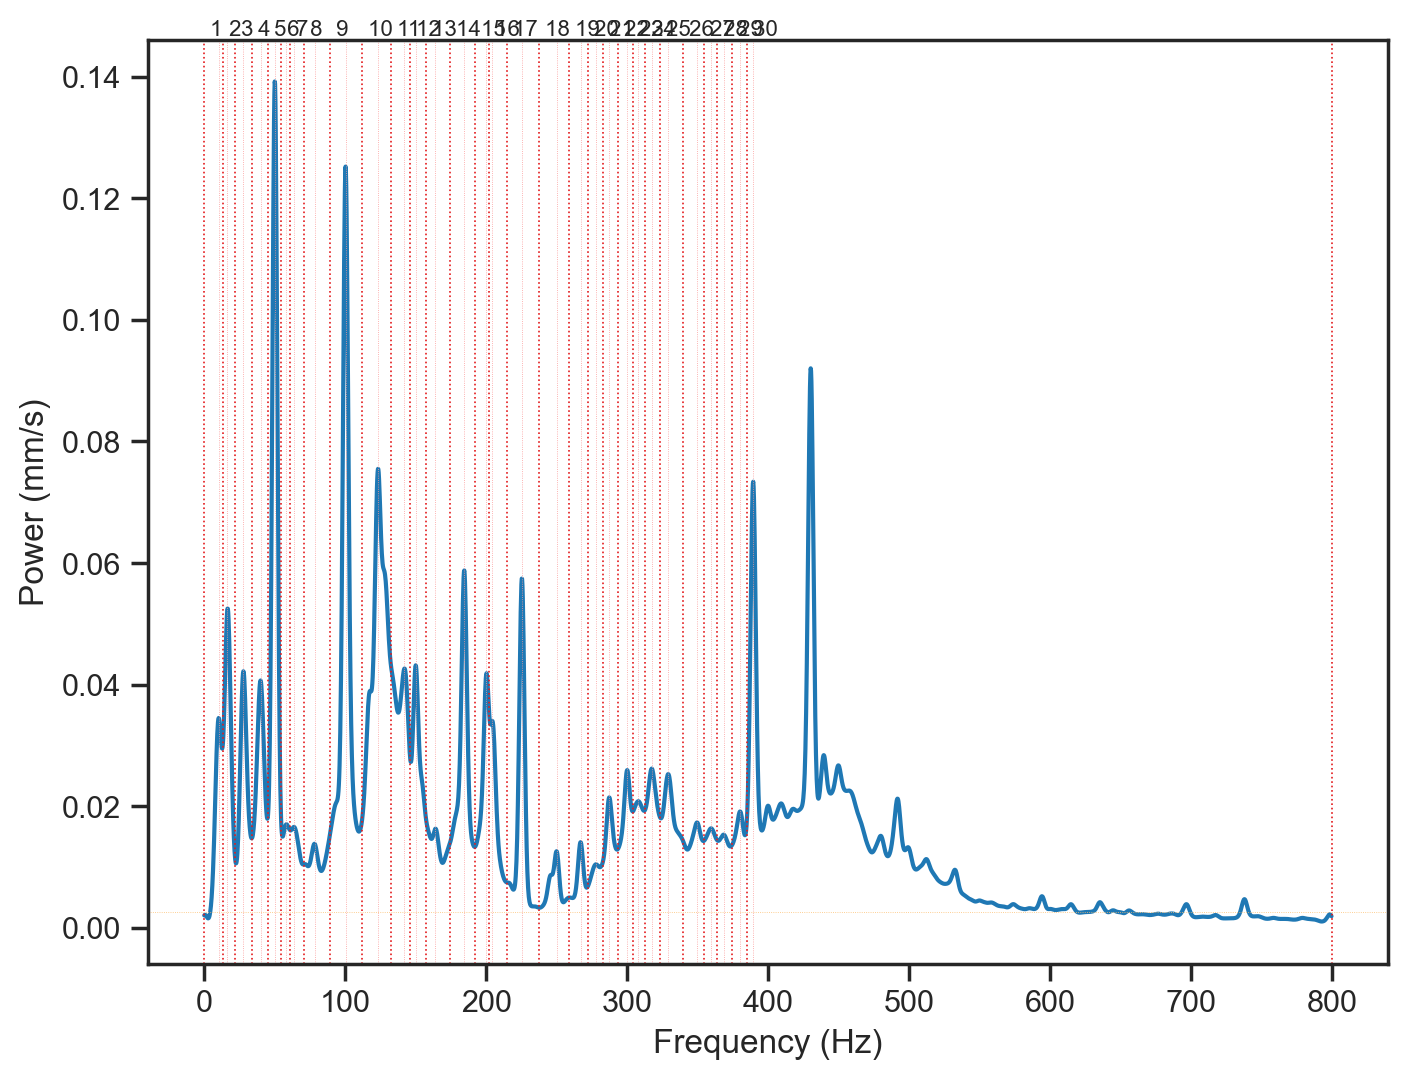

In [15]:
ax = pp.plot_tr_spectrum_with_annotations(PF_feat_extr_best)
# plt.savefig('plots/aligned_spectrum_25bands.png', dpi = 300)

## parameters check 

In [16]:
freq_vel_tr = PF_feat_extr_best.fit(X)
freq_vel_tr

PFSpectraFeatExtr(agg_spectra_method='median', agg_spectrum_window_size=60,
                  fb_dist_shape_auc_feat=False, max_no_peaks=30,
                  peak_freq_power_feat=False, signal_window='gaussian',
                  spectrum_window_size=60)

### freq of spectrum

In [17]:
ax = freq_vel_tr.agg_spectrum_
ax

freq
0.00      0.002017
0.25      0.002082
0.50      0.002110
0.75      0.002103
1.00      0.002062
            ...   
798.75    0.002191
799.00    0.002155
799.25    0.002091
799.50    0.002000
799.75    0.001885
Name: vel, Length: 3200, dtype: float64

#### bands frequency range

In [18]:
## bands frequency range
cut_points = freq_vel_tr.cut_points_
len(cut_points), cut_points

(31,
 array([  0.   ,  13.375,  22.125,  33.875,  45.   ,  54.125,  60.875,
         70.875,  89.25 , 111.75 , 132.625, 146.   , 157.   , 174.25 ,
        192.375, 202.25 , 214.75 , 237.625, 258.5  , 272.5  , 282.625,
        293.625, 304.   , 312.75 , 323.375, 339.5  , 354.625, 364.   ,
        374.375, 384.875, 799.75 ]))

#### peak frequency

In [19]:
peaks = freq_vel_tr.peaks_
len(peaks), peaks

(30,
 0      10.25
 1      16.50
 2      27.75
 3      40.00
 4      50.00
 5      58.25
 6      63.50
 7      78.25
 8     100.25
 9     123.25
 10    142.00
 11    150.00
 12    164.00
 13    184.50
 14    200.25
 15    204.25
 16    225.25
 17    250.00
 18    267.00
 19    278.00
 20    287.25
 21    300.00
 22    308.00
 23    317.50
 24    329.25
 25    349.75
 26    359.50
 27    368.50
 28    380.25
 29    389.50
 Name: freq, dtype: float64)

In [20]:
base_level= freq_vel_tr.peaks_base_level
base_level

0.0025

# [0.978]K-fold cross validation

In [19]:
X_extracted = reg_pipe_best.named_steps['pp'].transform(X)
X_extracted.shape # 30x2 +5 

(100, 65)

In [20]:
model = reg_pipe_best.named_steps['reg']
model

RandomForestRegressor(random_state=0)

R2 for fold 0: 0.993276
R2 for fold 1: 0.990268
R2 for fold 2: 0.963384
R2 for fold 3: 0.953706
R2 for fold 4: 0.988382
Average R2:  0.9778032178252442


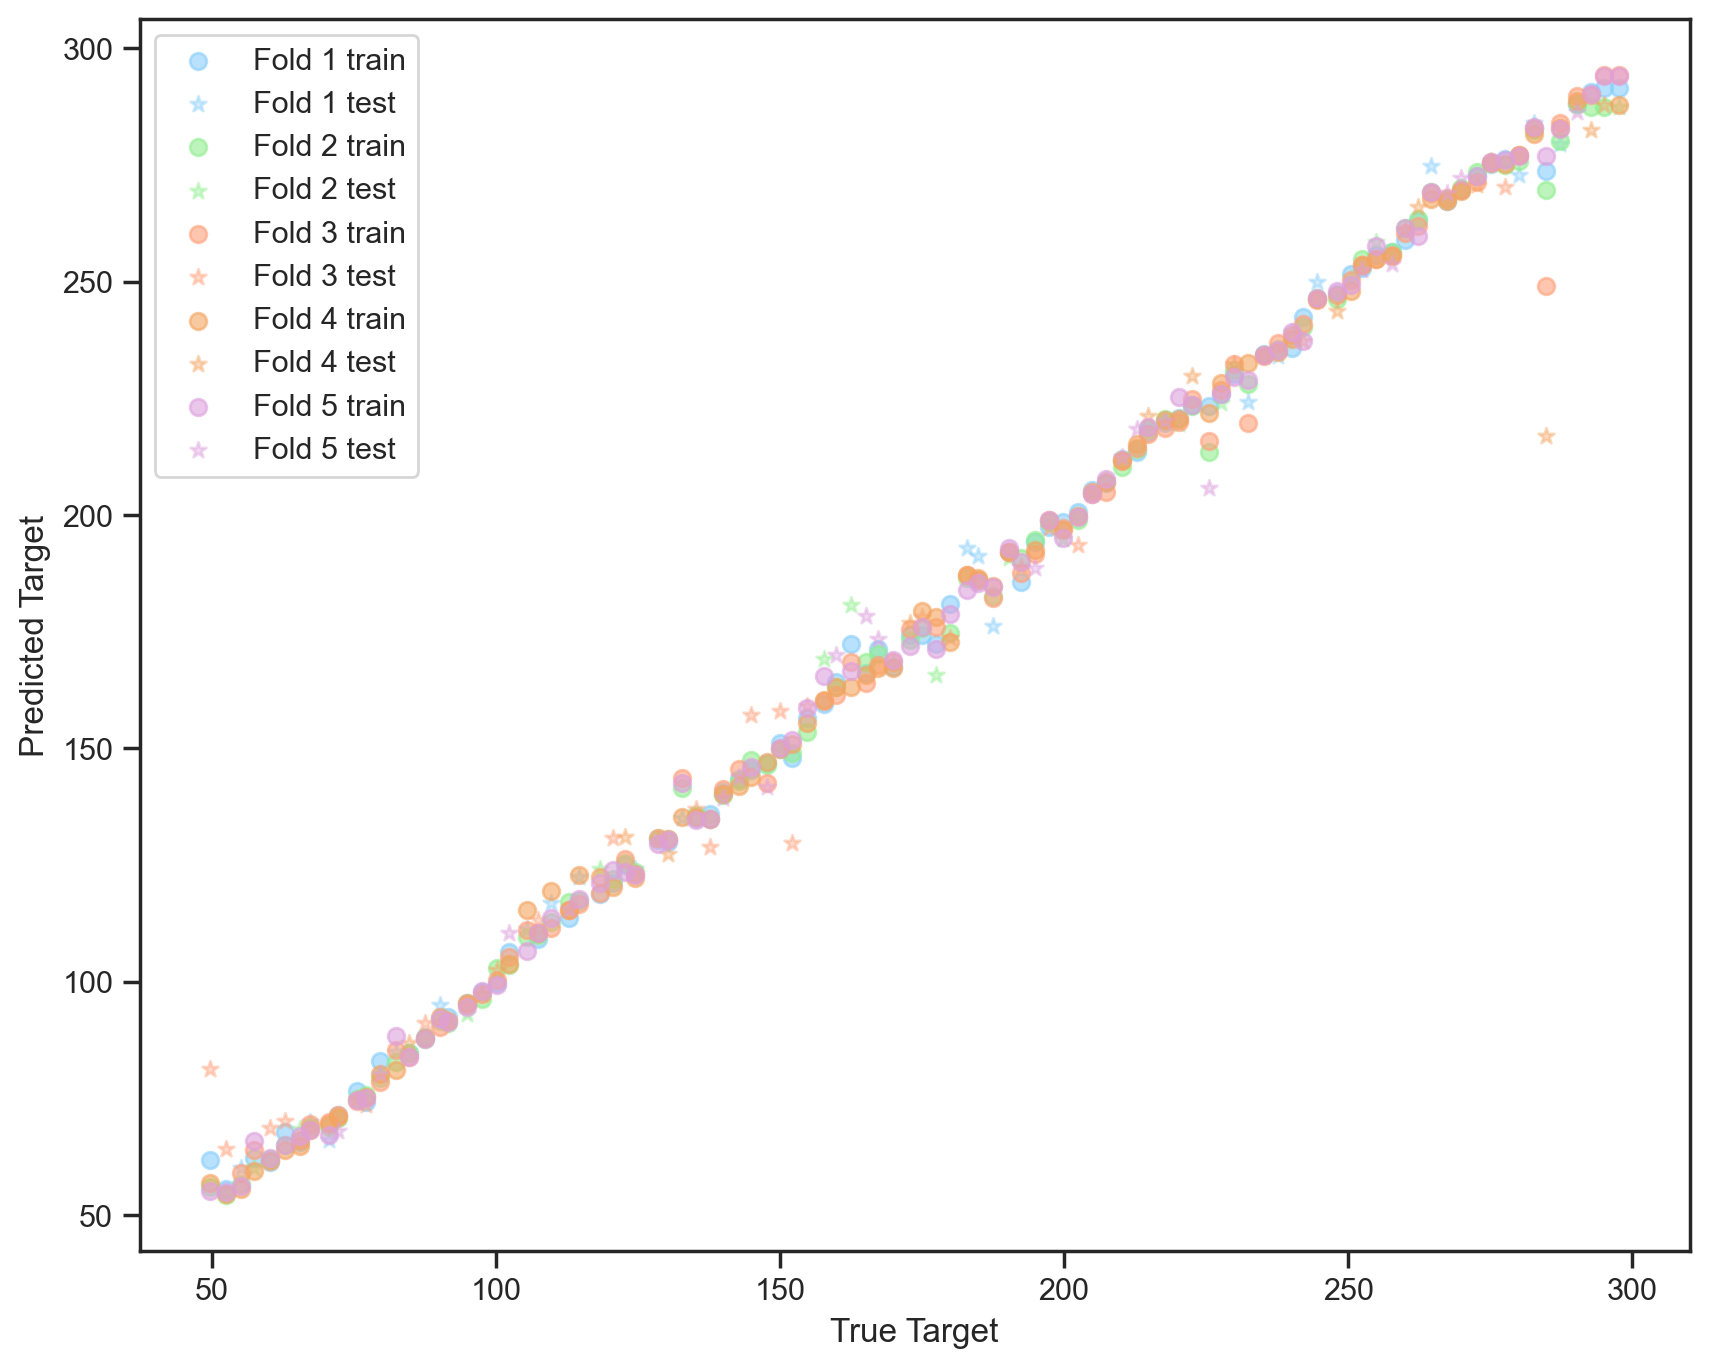

In [21]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score, explained_variance_score as evs
from sklearn.model_selection import KFold

MAEs = []
RMSEs = []
MADs = []
MAPEs = []
R2s = []
EVs = []

kfold = KFold(n_splits=5, shuffle=True, random_state=0)

predicted_all = []
y_true_all = []



plt.figure(figsize=(10, 8))
for i, (train_idx, test_idx) in enumerate(kfold.split(X_extracted)):
    X_train_fold = X_extracted.loc[train_idx]
    X_test_fold = X_extracted.loc[test_idx]
    
    y_train_fold = y[train_idx]
    y_test_fold = y[test_idx]
    
    model = reg_pipe_best.named_steps['reg']
    
    model_fitted = model.fit(X_train_fold,y_train_fold)
    
    y_pred_train = model_fitted.predict(X_train_fold)
    y_pred_test = model_fitted.predict(X_test_fold)
    
    
    MAEs.append(mae(y_test_fold, y_pred_test))
    RMSEs.append(np.sqrt(mse(y_test_fold, y_pred_test)))
    MADs.append(np.median(np.abs(y_test_fold - y_pred_test)))
    MAPEs.append(np.mean(np.abs((y_test_fold - y_pred_test) / y_test_fold)) * 100)
    R2s.append(r2_score(y_test_fold, y_pred_test))
    EVs.append(evs(y_test_fold, y_pred_test))
    
    print(f"R2 for fold {i}: {np.mean(r2_score(y_test_fold, y_pred_test)):.6f}")
    
    
    colors = ['lightskyblue','lightgreen','lightsalmon','sandybrown','plum']
    
    plt.scatter(y_train_fold, y_pred_train, label=f'Fold {i+1} train'
                , color = colors[i]
                ,alpha=0.6)
    plt.scatter(y_test_fold, y_pred_test, marker='*', label=f'Fold {i+1} test'
                ,color = colors[i]
                ,alpha=0.4)
    
    
print("Average R2: ", np.mean(R2s))
plt.xlabel('True Target')
plt.ylabel('Predicted Target')
plt.legend()

# plt.savefig('111.png')
plt.show()

# Feature Selection

## Sequantial Feature Selection

In [22]:
from sklearn.feature_selection import SequentialFeatureSelector

rf = reg_pipe_best.named_steps['reg']

### feature extraction 

In [23]:
X_extracted = reg_pipe_best.named_steps['pp'].transform(X)

X_train_extracted = reg_pipe_best.named_steps['pp'].transform(X_train)
X_test_extracted = reg_pipe_best.named_steps['pp'].transform(X_test)

X_extracted.shape, X_train_extracted.shape

((100, 65), (80, 65))

### feature selection

In [24]:
sfs = SequentialFeatureSelector(reg_pipe_best.named_steps['reg'], 
                                n_features_to_select=None,
                                direction='forward',
                                scoring='r2',
                                cv=5)


sfs.fit(X_train_extracted, y_train)


selected_features = X_train_extracted.columns[sfs.get_support()].tolist()

In [25]:
len(selected_features), selected_features

(32,
 ['b1_freq',
  'b2_freq',
  'b4_freq',
  'b5_freq',
  'b5_power',
  'b6_freq',
  'b8_freq',
  'b9_freq',
  'b11_freq',
  'b11_power',
  'b12_freq',
  'b13_freq',
  'b14_freq',
  'b14_power',
  'b15_freq',
  'b15_power',
  'b16_freq',
  'b17_freq',
  'b18_power',
  'b20_freq',
  'b20_power',
  'b21_power',
  'b24_freq',
  'b26_freq',
  'b26_power',
  'b28_freq',
  'b29_freq',
  'b29_power',
  'b30_power',
  'mean',
  'skew',
  'auc'])

In [26]:
from sklearn.model_selection import cross_val_score

cv_scores = []


for n in range(1, len(selected_features)*2):
    selected_feats = selected_features[:n]
    X_train_sub = X_train_extracted[selected_feats]
    score = cross_val_score(rf, X_train_sub, y_train, cv=5, scoring='r2').mean()
    cv_scores.append(score)


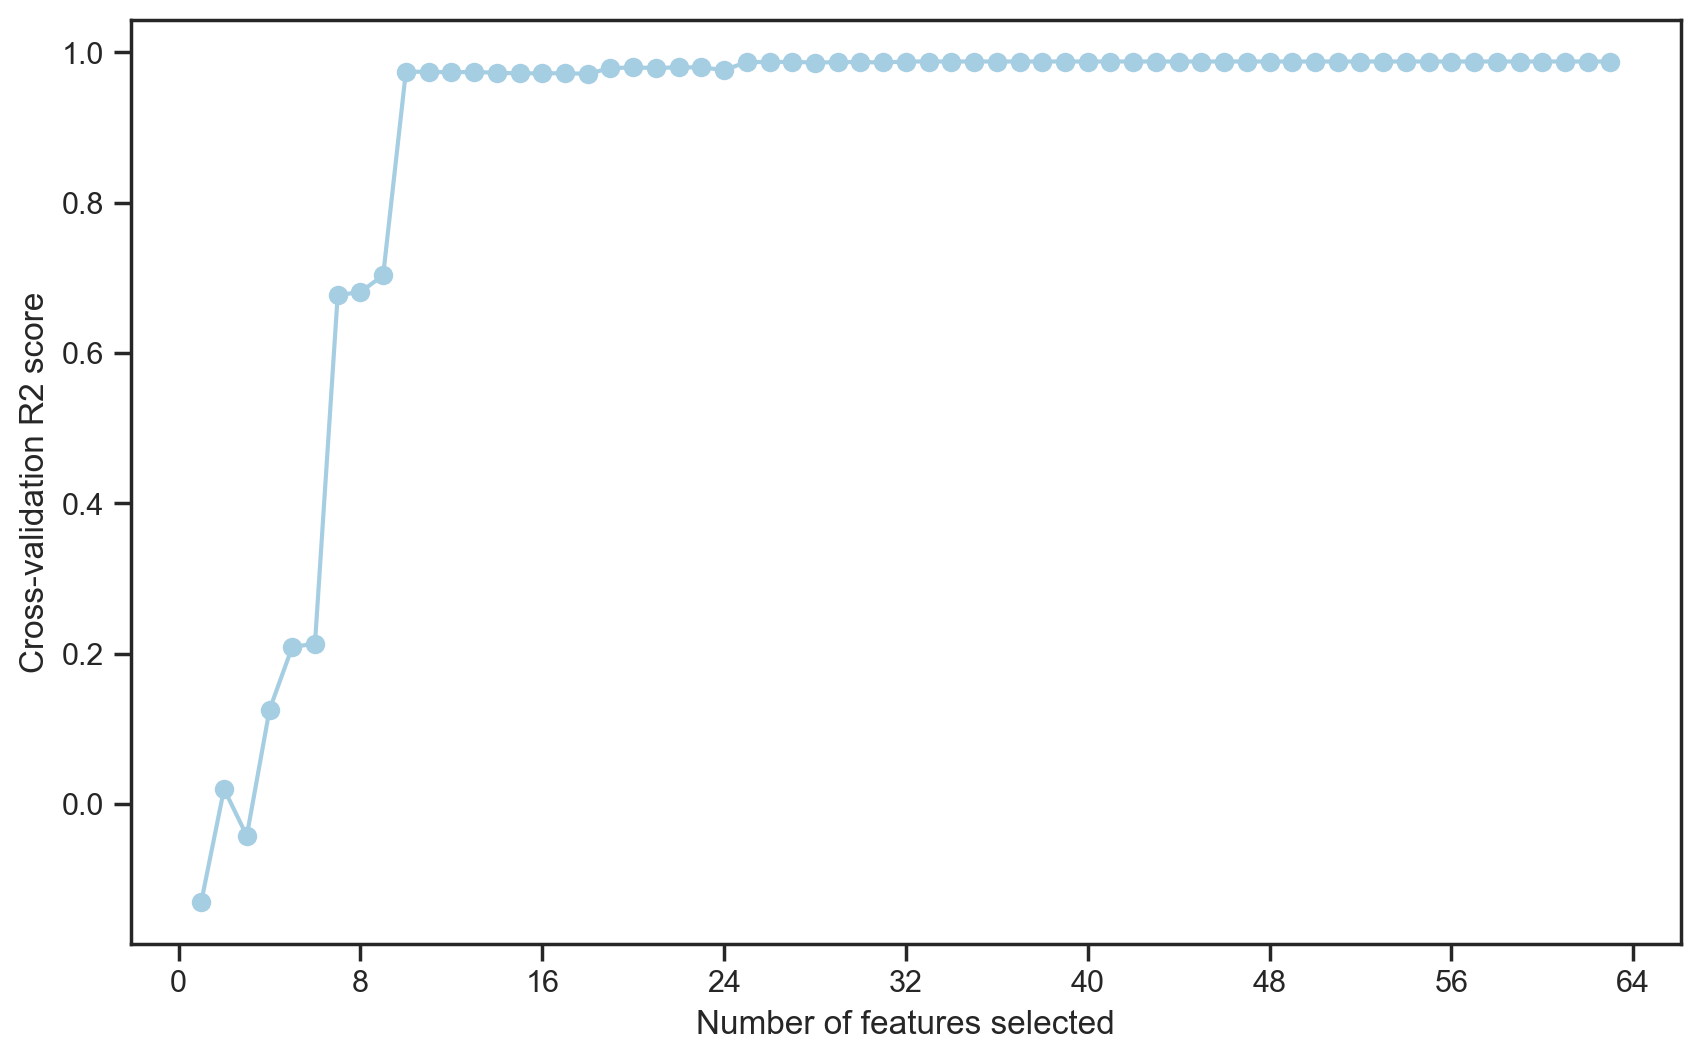

In [27]:
from matplotlib.ticker import MaxNLocator

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(selected_features)*2), cv_scores, marker='o', linestyle='-')
plt.xlabel('Number of features selected')
plt.ylabel('Cross-validation R2 score')


ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()


In [75]:
cv_scores[:8]

[0.14383041468606622,
 0.21954256049185297,
 0.6724217159205796,
 0.82326458068345,
 0.9425397322516407,
 0.9436053354231003,
 0.9643250227084114,
 0.9625566894398521]

In [76]:
top7_selected_features = selected_features[0:7]
top7_selected_features

['b2_freq',
 'b6_freq',
 'b6_power',
 'b7_freq',
 'b7_power',
 'b8_freq',
 'b8_power']

In [78]:
X_subset_SFS = X_extracted[top7_selected_features]
X_subset_SFS.shape

(100, 7)

### [0.972]

R2 for fold 1: 0.983599
R2 for fold 2: 0.971508
R2 for fold 3: 0.979135
R2 for fold 4: 0.947374
R2 for fold 5: 0.980118
Average R2:  0.9723468202139298


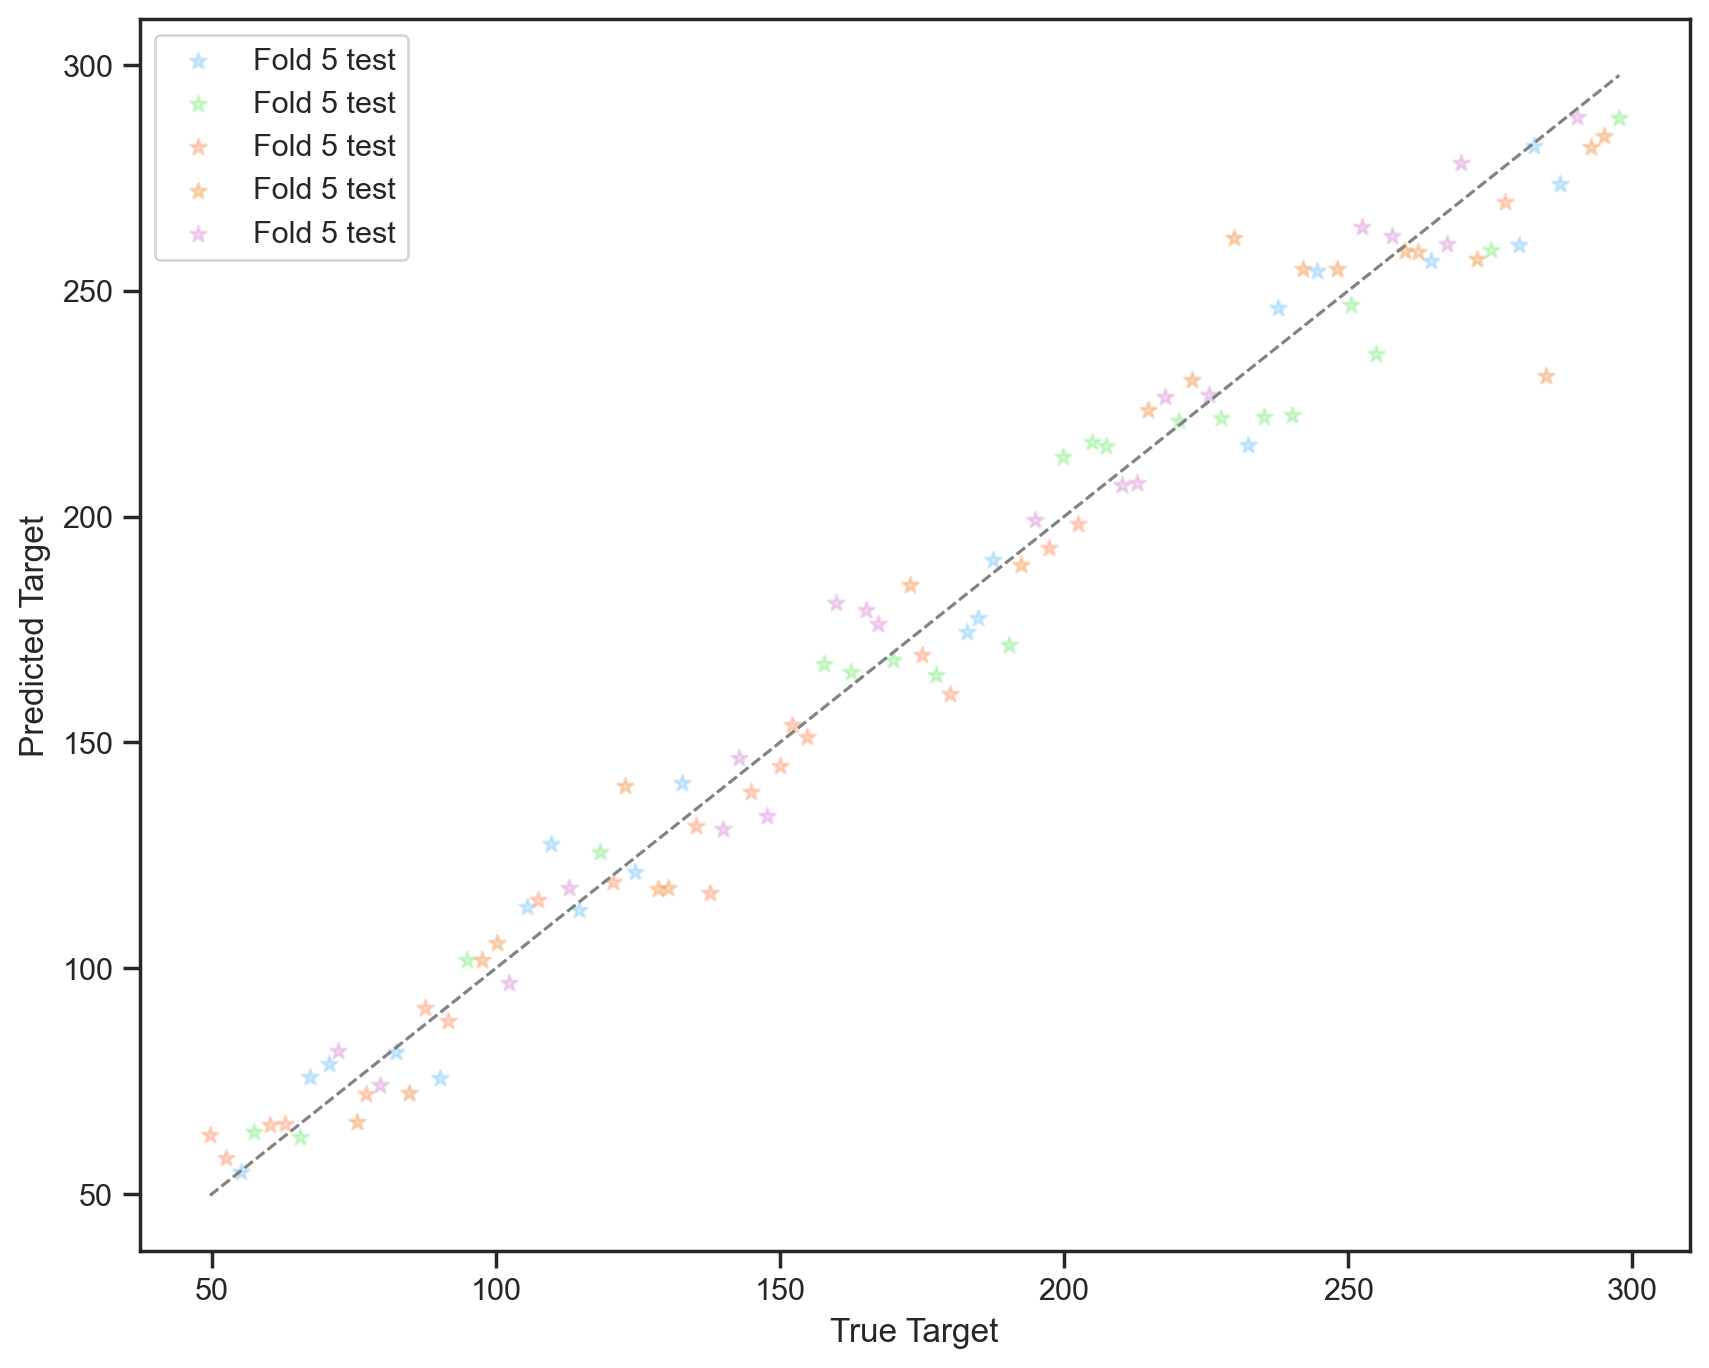

In [80]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score, explained_variance_score as evs
from sklearn.model_selection import KFold, cross_val_predict

MAEs = []
RMSEs = []
MADs = []
MAPEs = []
R2s = []
EVs = []

kf = KFold(n_splits=5, shuffle=True, random_state=0)
predicted_all = []
y_true_all = []

fold_num = 1

plt.figure(figsize=(10, 8))
for train_index, test_index in kf.split(X_subset_SFS):
    
    X_train_fold, X_test_fold = X_subset_SFS.iloc[train_index], X_subset_SFS.iloc[test_index]
    y_train_fold, y_test_fold = y.iloc[train_index], y.iloc[test_index]
    
#     print(X_train_fold.columns)
    
    model = rf.fit(X_train_fold, y_train_fold)
    
    y_pred_train = model.predict(X_train_fold)
    y_pred_test = model.predict(X_test_fold)
    
    MAEs.append(mae(y_test_fold, y_pred_test))
    RMSEs.append(np.sqrt(mse(y_test_fold, y_pred_test)))
    MADs.append(np.median(np.abs(y_test_fold - y_pred_test)))
    MAPEs.append(np.mean(np.abs((y_test_fold - y_pred_test) / y_test_fold)) * 100)
    R2s.append(r2_score(y_test_fold, y_pred_test))
    EVs.append(evs(y_test_fold, y_pred_test))
    
#     print("R2: ", np.mean(r2_score(y_test_fold, y_pred_test)))
    print(f"R2 for fold {fold_num}: {np.mean(r2_score(y_test_fold, y_pred_test)):.6f}")
    
    
    colors = ['lightskyblue','lightgreen','lightsalmon','sandybrown','plum']
    
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', lw=1,color='gray', alpha=0.5)
    
    plt.scatter(y_test_fold, y_pred_test, marker='*', label=f'Fold {i+1} test'
                ,color = colors[fold_num-1]
                ,alpha=0.4)
    
    fold_num += 1
    
print("Average R2: ", np.mean(R2s))
plt.xlabel('True Target')
plt.ylabel('Predicted Target')
plt.legend()

# plt.savefig('test.png')
    
    
plt.show()

### SHAP analysis

In [82]:
import shap

explainer = shap.TreeExplainer(reg_pipe_best.named_steps['reg'])


In [83]:
shap_values = explainer.shap_values(X_subset_SFS)


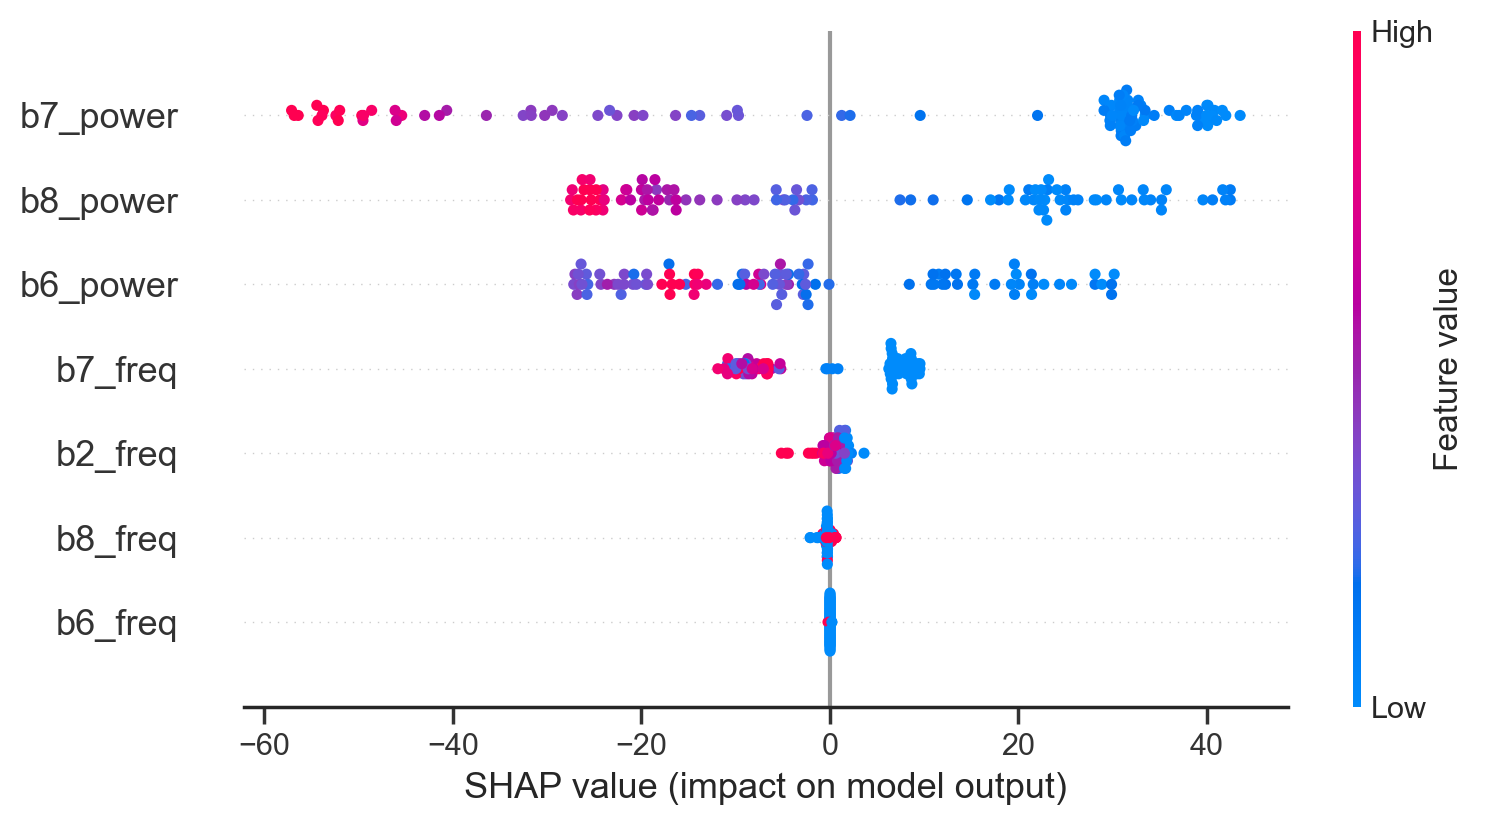

In [84]:
shap.summary_plot(shap_values, X_subset_SFS)


### relation with target 

#### correlation 

In [85]:
correlation_with_target = X_subset_SFS.join(y).corr()['flow_rate'].iloc[:-1]
correlation_with_target

b2_freq    -0.076533
b6_freq    -0.417234
b6_power   -0.740263
b7_freq    -0.568179
b7_power   -0.874706
b8_freq     0.454818
b8_power   -0.928239
Name: flow_rate, dtype: float64

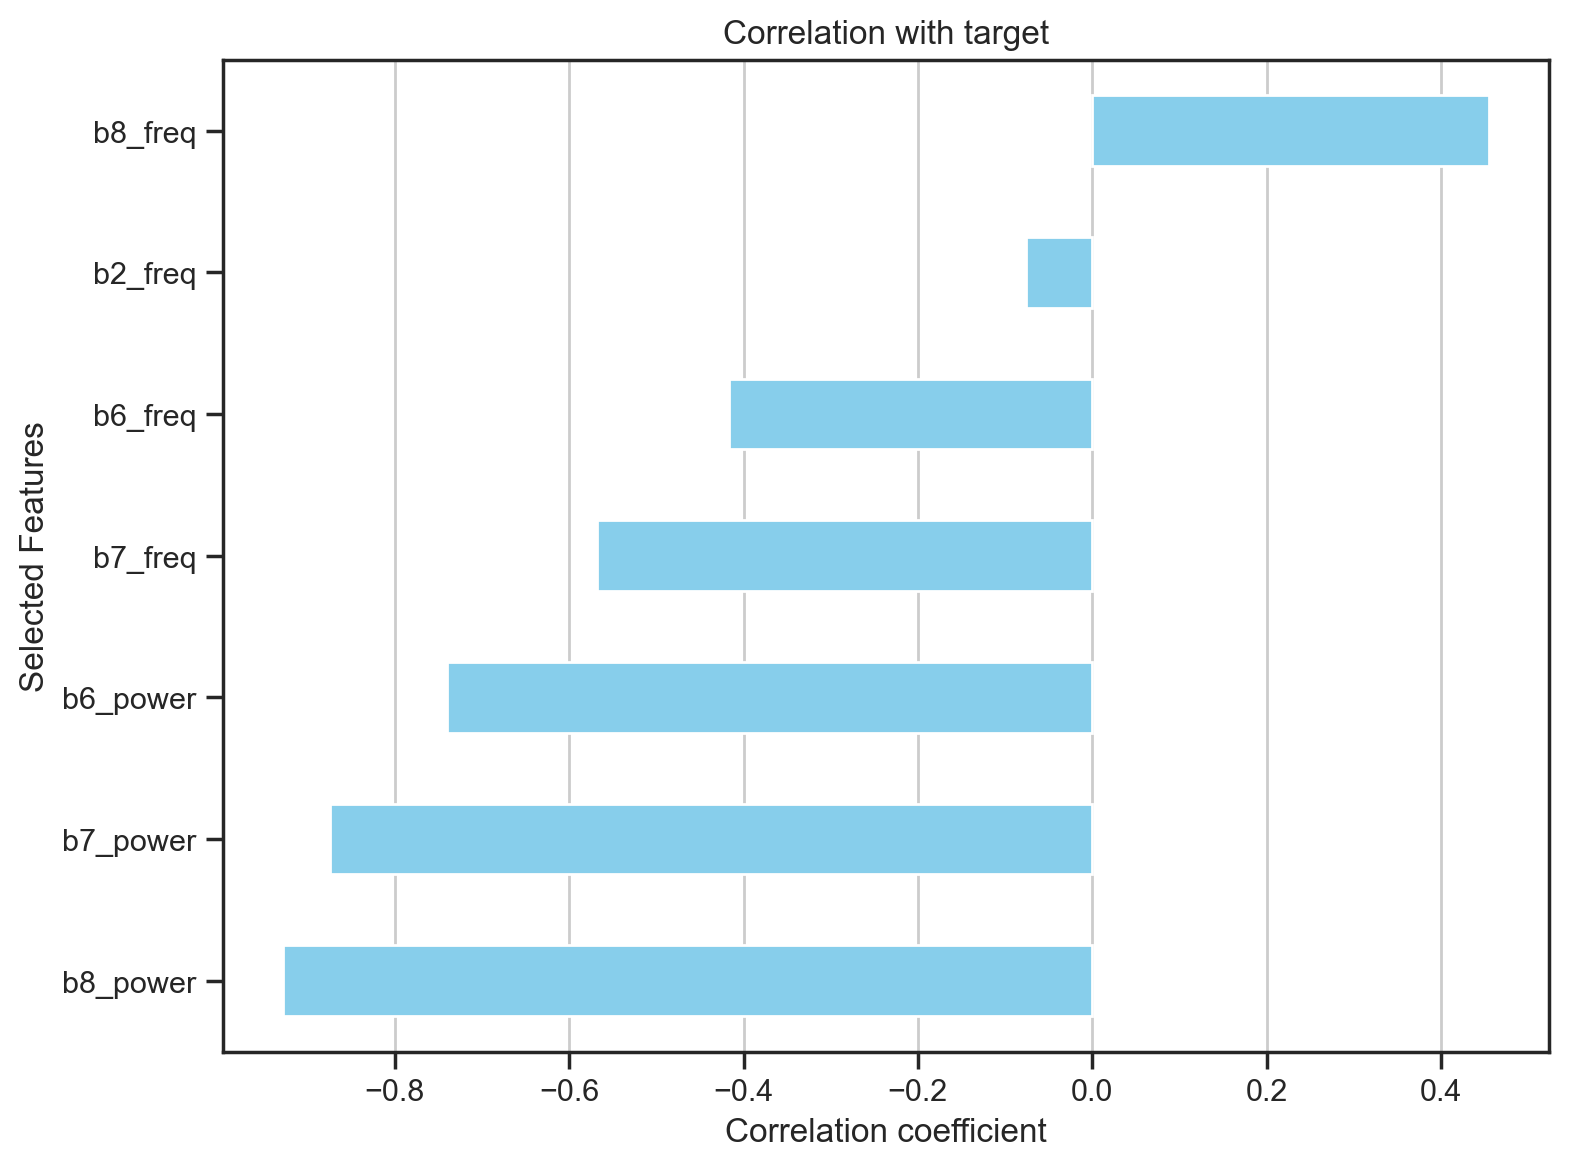

In [86]:
correlation_with_target.sort_values().plot(kind='barh', color='skyblue')


plt.title('Correlation with target')
plt.xlabel('Correlation coefficient')
plt.ylabel('Selected Features')
plt.grid(axis='x')
plt.tight_layout()
plt.show()


#### importance 

In [87]:
rf.fit(X_subset_SFS, y)
feature_importance_selected = rf.feature_importances_


In [88]:
feature_importance_selected

array([8.06248112e-03, 4.23324824e-05, 1.03463769e-01, 2.10604543e-01,
       3.30364399e-01, 5.47206180e-04, 3.46915270e-01])

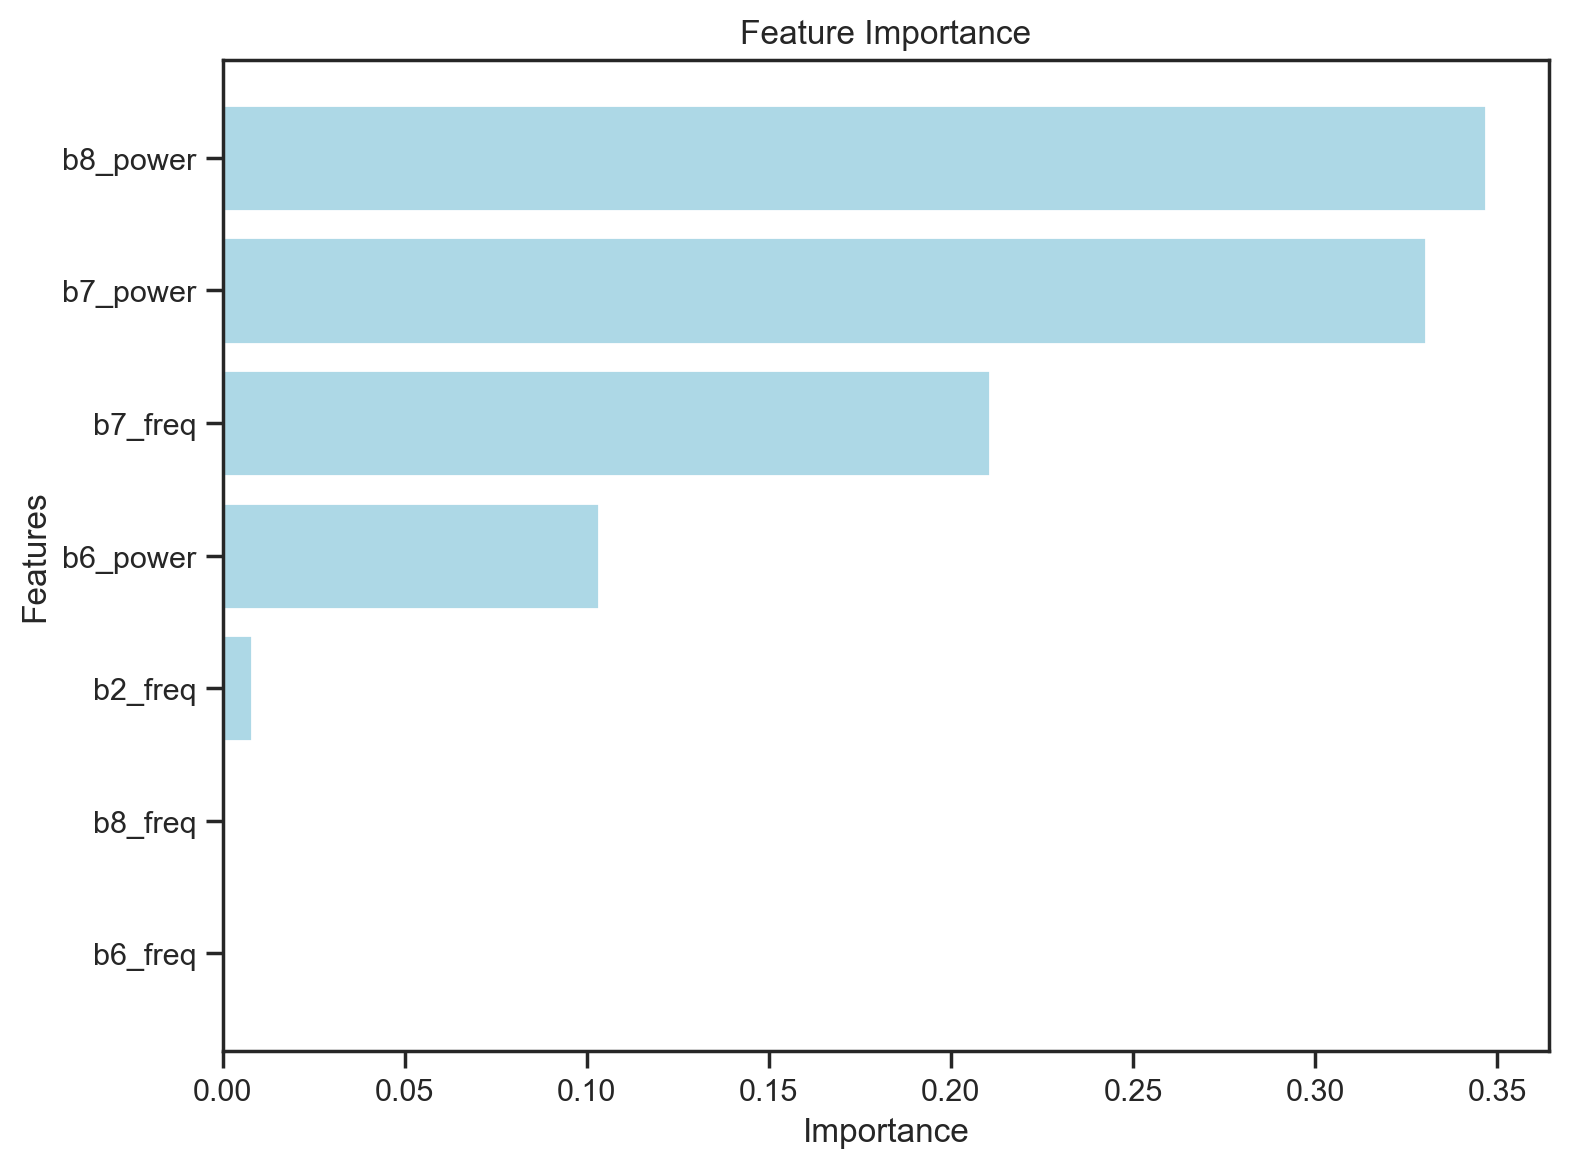

In [89]:
rf.fit(X_subset_SFS, y)


feature_importance_selected = rf.feature_importances_


features = list(X_subset_SFS.columns)
feature_importance_pairs = sorted(zip(features, feature_importance_selected), key=lambda x: x[1], reverse=True)


features_sorted, importances_sorted = zip(*feature_importance_pairs)


plt.figure(figsize=(8, 6))
plt.barh(features_sorted, importances_sorted, color='lightblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis()  # making the most important feature at the top
plt.tight_layout()
plt.show()

#### distribution

In [90]:
X_subset_SFS.shape

(100, 7)

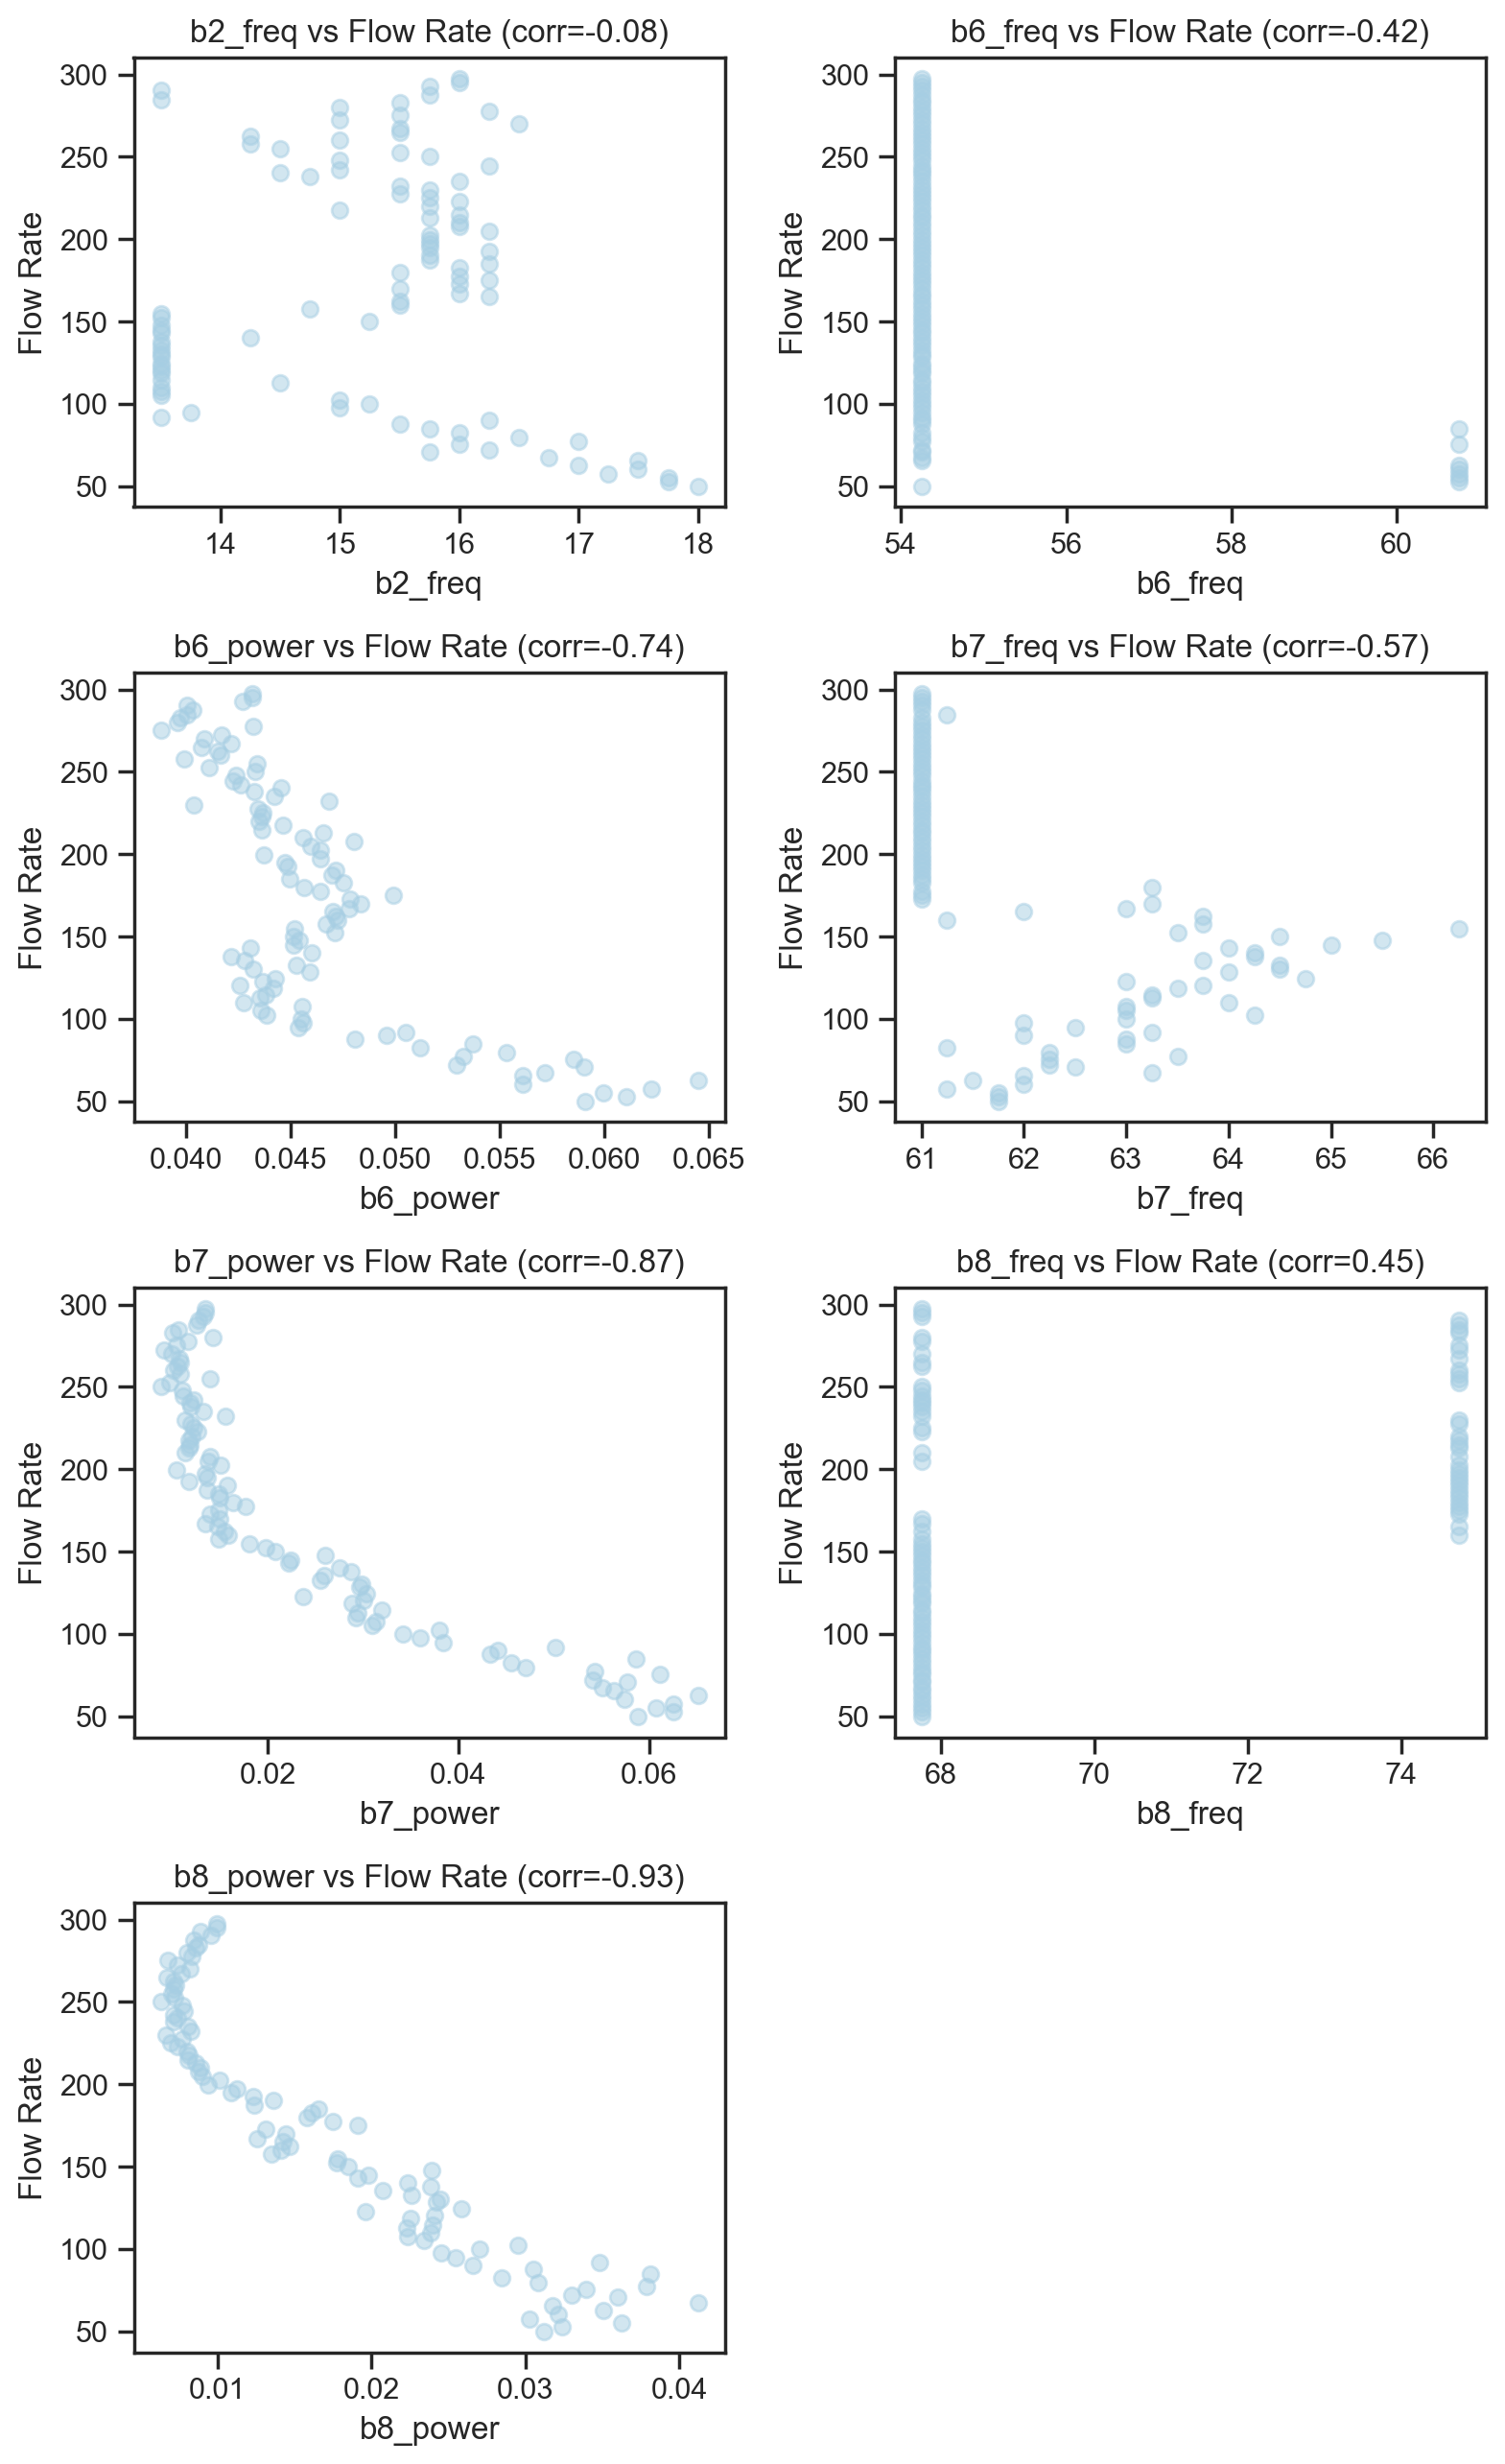

In [94]:
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(8, 13))

fig.delaxes(axes[3][1])

for idx, feature in enumerate(X_subset_SFS.columns):
    ax = axes[idx // 2, idx % 2]
    ax.scatter(X_subset_SFS[feature], y, alpha=0.5)
    ax.set_title(f'{feature} vs Flow Rate (corr={correlation_with_target[feature]:.2f})')
    ax.set_xlabel(feature)
    ax.set_ylabel('Flow Rate')

    
plt.tight_layout()
plt.show()


## PCA

### feature extraction

In [104]:
X_extracted = reg_pipe_best.named_steps['pp'].transform(X)

X_train_extracted = reg_pipe_best.named_steps['pp'].transform(X_train)
X_test_extracted = reg_pipe_best.named_steps['pp'].transform(X_test)

X_extracted.shape, X_train_extracted.shape

((100, 65), (80, 65))

### feature selection

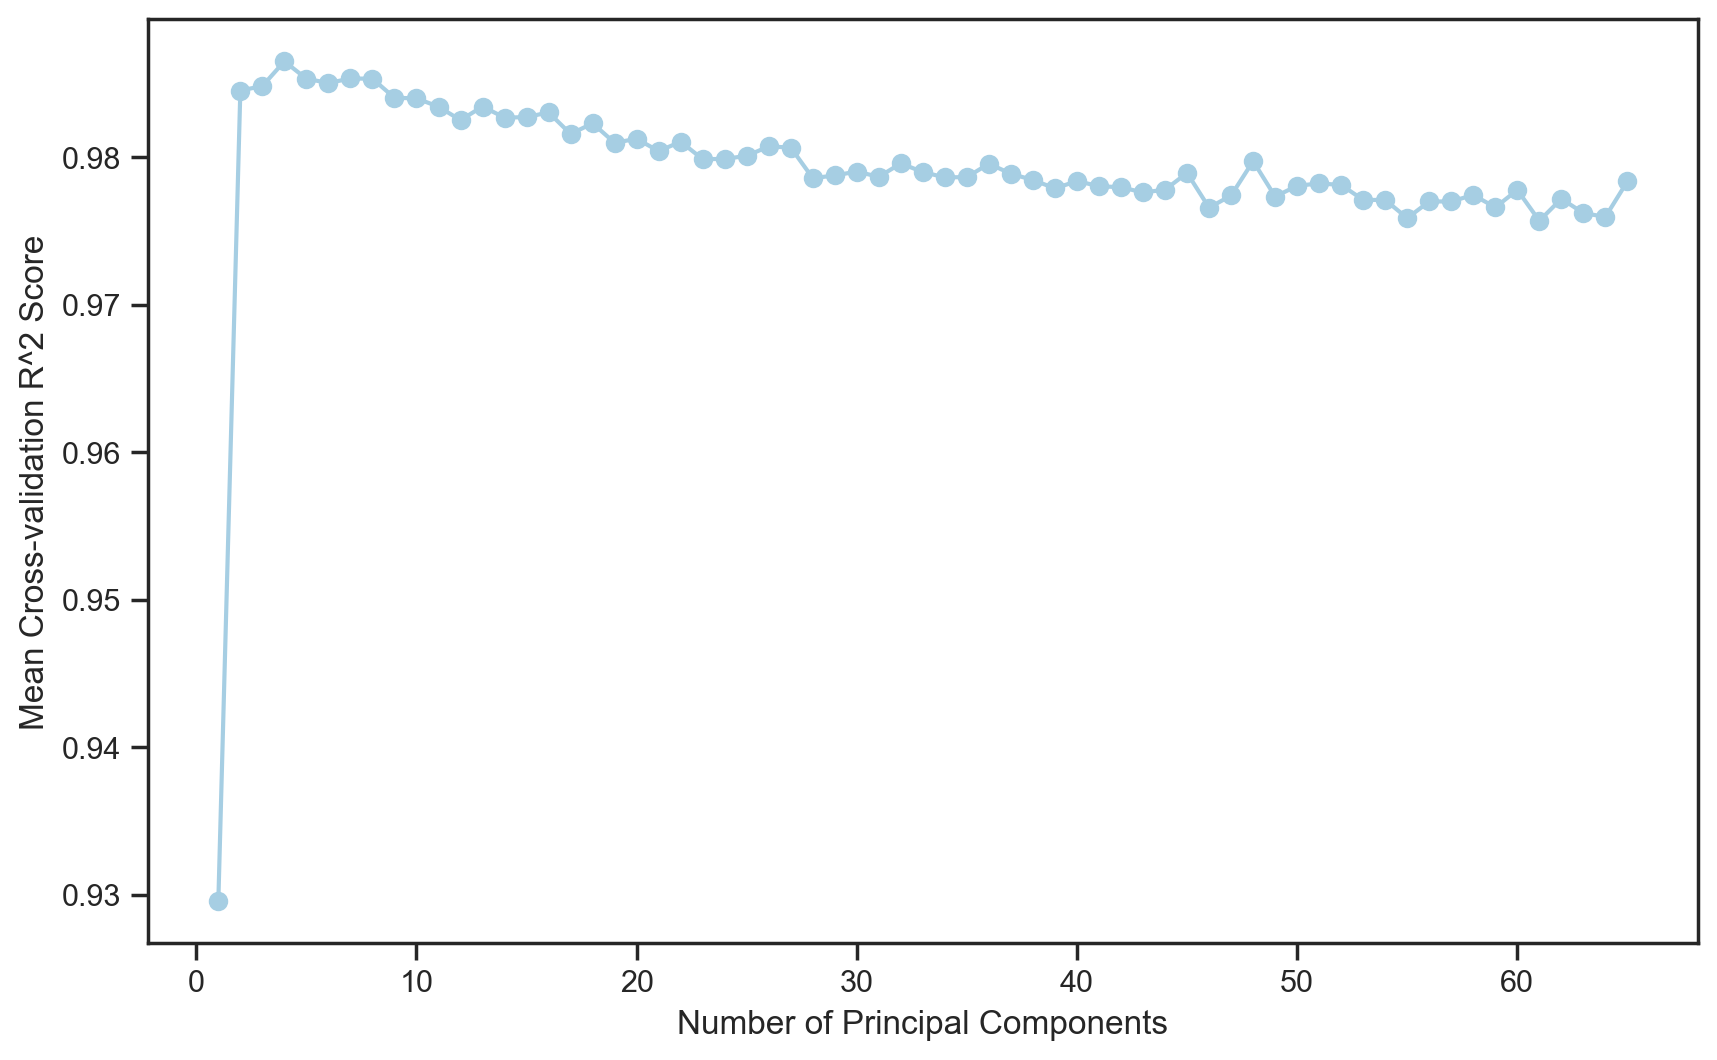

In [105]:
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler 


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_extracted)


kf = KFold(n_splits=5)

component_counts = []
scores = []


for i in range(1, X_train_scaled.shape[1] + 1):
    pca = PCA(n_components=i)
    X_pca_transformed = pca.fit_transform(X_train_scaled)
    
    score = cross_val_score(rf, X_pca_transformed, y_train, cv=kf, scoring='r2').mean()
    
    component_counts.append(i)
    scores.append(score)


plt.figure(figsize=(10, 6))
plt.plot(component_counts, scores, marker='o')
plt.xlabel("Number of Principal Components")
plt.ylabel("Mean Cross-validation R^2 Score")
plt.show()


In [106]:
scores[0:4]

[0.9295463568856448, 0.9845059677203057, 0.9848136135807366, 0.986486845576008]

In [107]:
# X_extracted 降到4维 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_extracted)

pca = PCA(n_components=4)
X_pca_transformed = pca.fit_transform(X_scaled)

X_pca_transformed.shape

(100, 4)

In [108]:
X_pca_transformed_df = pd.DataFrame(X_pca_transformed, columns =["PC1", "PC2", "PC3", "PC4"])
X_pca_transformed_df

PC1       PC2       PC3       PC4
0    9.510337  2.555028 -3.429064  1.994465
1   10.848732  1.673708 -3.927089  1.919871
2   10.261260  2.030895 -4.479936  1.595757
3    9.423878  2.699582 -4.009000  2.137150
4    8.804707  2.294015 -3.638057  0.753625
..        ...       ...       ...       ...
95  -6.060822  4.428834 -1.081925  1.315012
96  -5.339410  5.513167 -0.555172  3.155235
97  -5.126617  5.277038 -0.685999  3.034303
98  -3.851242  5.682854  0.049927  4.253363
99  -3.851242  5.682854  0.049927  4.253363

[100 rows x 4 columns]

### [0.985]

R2 for fold 0: 0.989229
R2 for fold 1: 0.991059
R2 for fold 2: 0.976558
R2 for fold 3: 0.993344
R2 for fold 4: 0.976414
Average R2:  0.985320804076039


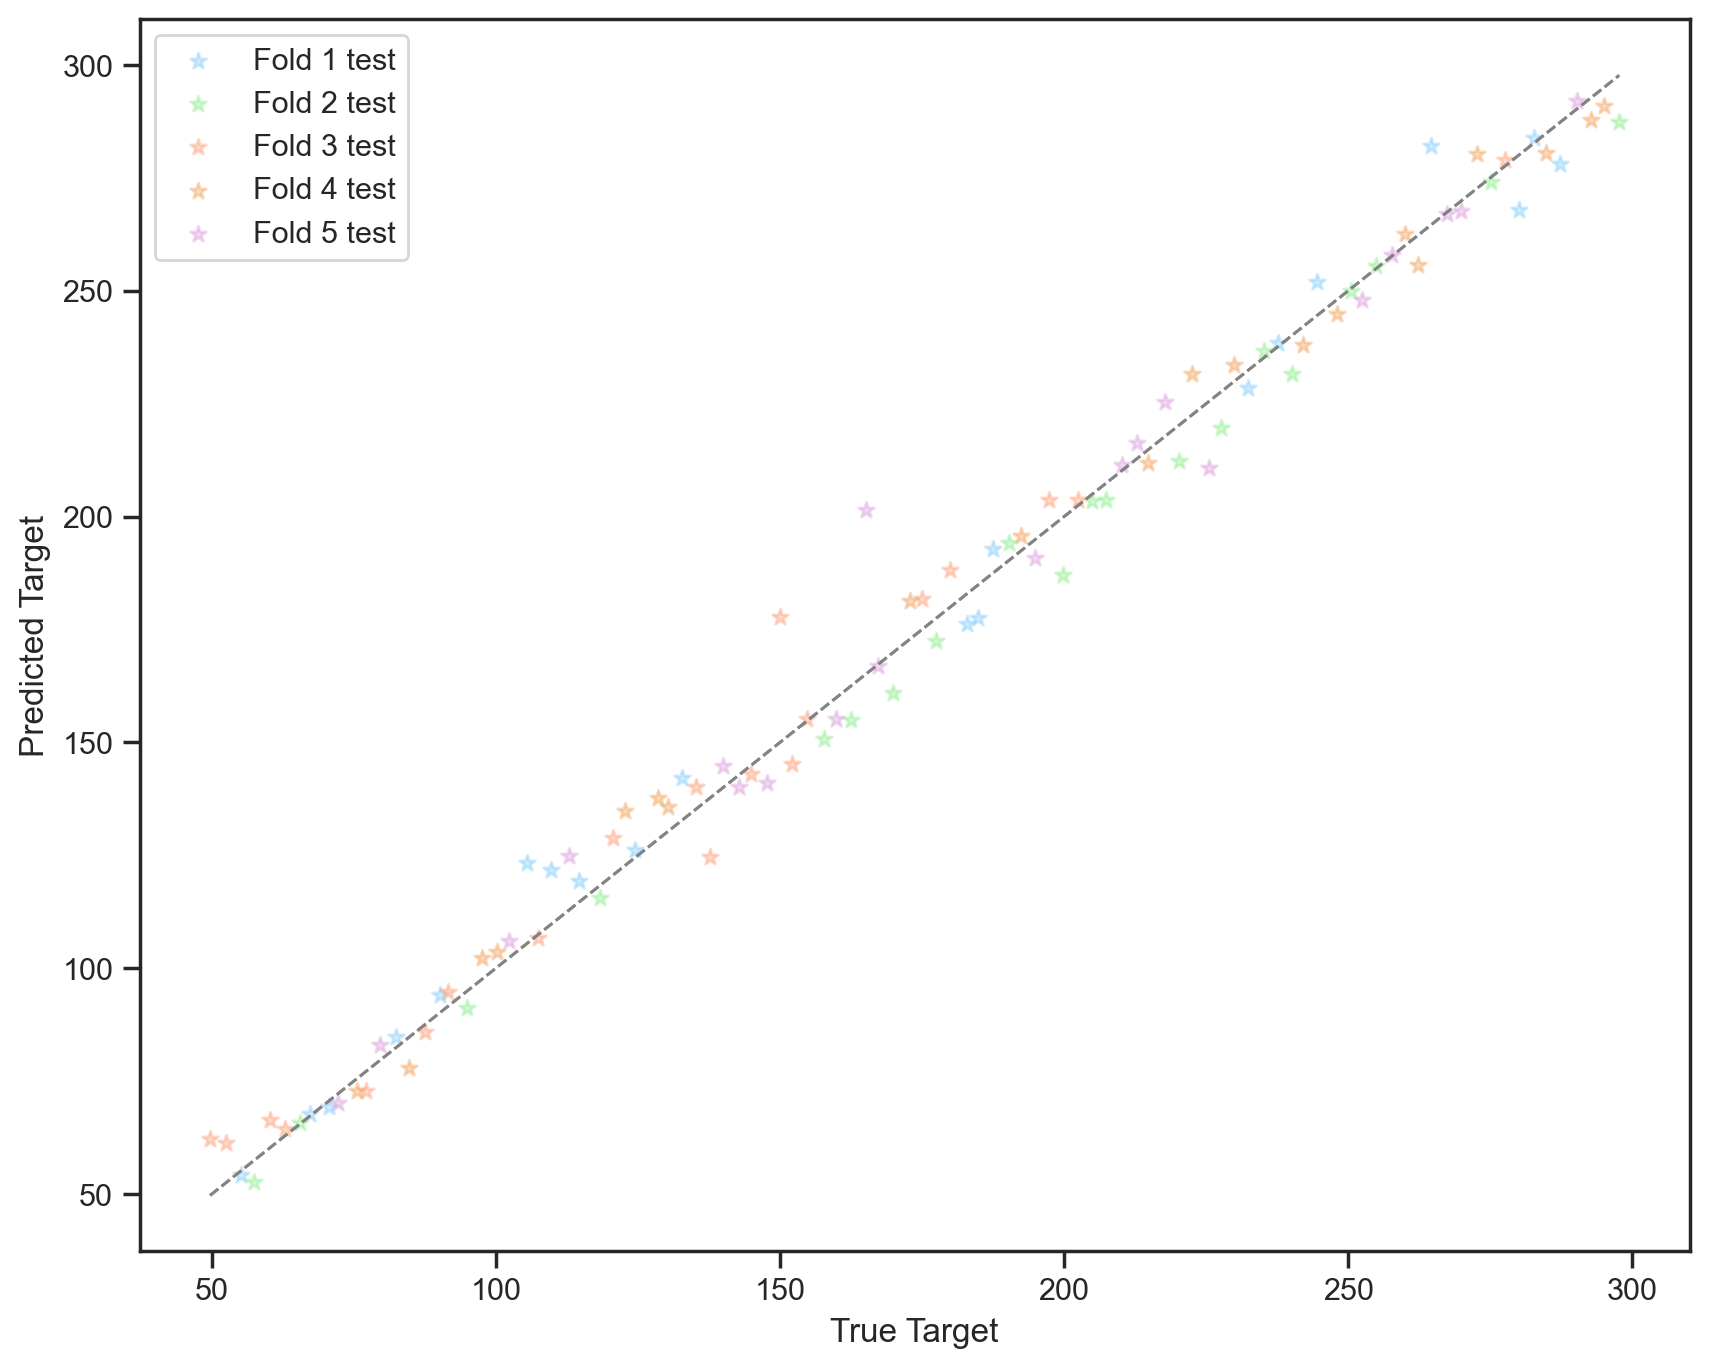

In [109]:
from sklearn.metrics import mean_absolute_error as mae, mean_squared_error as mse, r2_score, explained_variance_score as evs
from sklearn.model_selection import KFold


MAEs = []
RMSEs = []
MADs = []
MAPEs = []
R2s = []
EVs = []

kf = KFold(n_splits=5, shuffle=True, random_state=0)
predicted_all = []
y_true_all = []

# X_subset_AFS = X_extracted[selected_features_AFS]


plt.figure(figsize=(10, 8))
for i, (train_idx, test_idx) in enumerate(kf.split(X_pca_transformed_df)):
    X_train_fold = X_pca_transformed_df.loc[train_idx]
    X_test_fold = X_pca_transformed_df.loc[test_idx]
    
    y_train_fold = y[train_idx]
    y_test_fold = y[test_idx]
    
#     print(X_train_fold.columns)
    
    model = rf.fit(X_train_fold, y_train_fold)
    
    y_pred_train = model.predict(X_train_fold)
    y_pred_test = model.predict(X_test_fold)
    
    MAEs.append(mae(y_test_fold, y_pred_test))
    RMSEs.append(np.sqrt(mse(y_test_fold, y_pred_test)))
    MADs.append(np.median(np.abs(y_test_fold - y_pred_test)))
    MAPEs.append(np.mean(np.abs((y_test_fold - y_pred_test) / y_test_fold)) * 100)
    R2s.append(r2_score(y_test_fold, y_pred_test))
    EVs.append(evs(y_test_fold, y_pred_test))

#     print("R2: ", np.mean(r2_score(y_test_fold, y_pred_test)))
    print(f"R2 for fold {i}: {np.mean(r2_score(y_test_fold, y_pred_test)):.6f}")
    
    
    colors = ['lightskyblue','lightgreen','lightsalmon','sandybrown','plum']
    
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', lw=1,color='gray', alpha=0.5)
    
    plt.scatter(y_test_fold, y_pred_test, marker='*', label=f'Fold {i+1} test'
                ,color = colors[i]
                ,alpha=0.4)
    
print("Average R2: ", np.mean(R2s))
plt.xlabel('True Target')
plt.ylabel('Predicted Target')
plt.legend()

# plt.savefig('test.png')
    
    
plt.show()

### SHAP analysis 

In [110]:
explainer = shap.TreeExplainer(reg_pipe_best.named_steps['reg'])


In [111]:
shap_values = explainer.shap_values(X_pca_transformed_df)


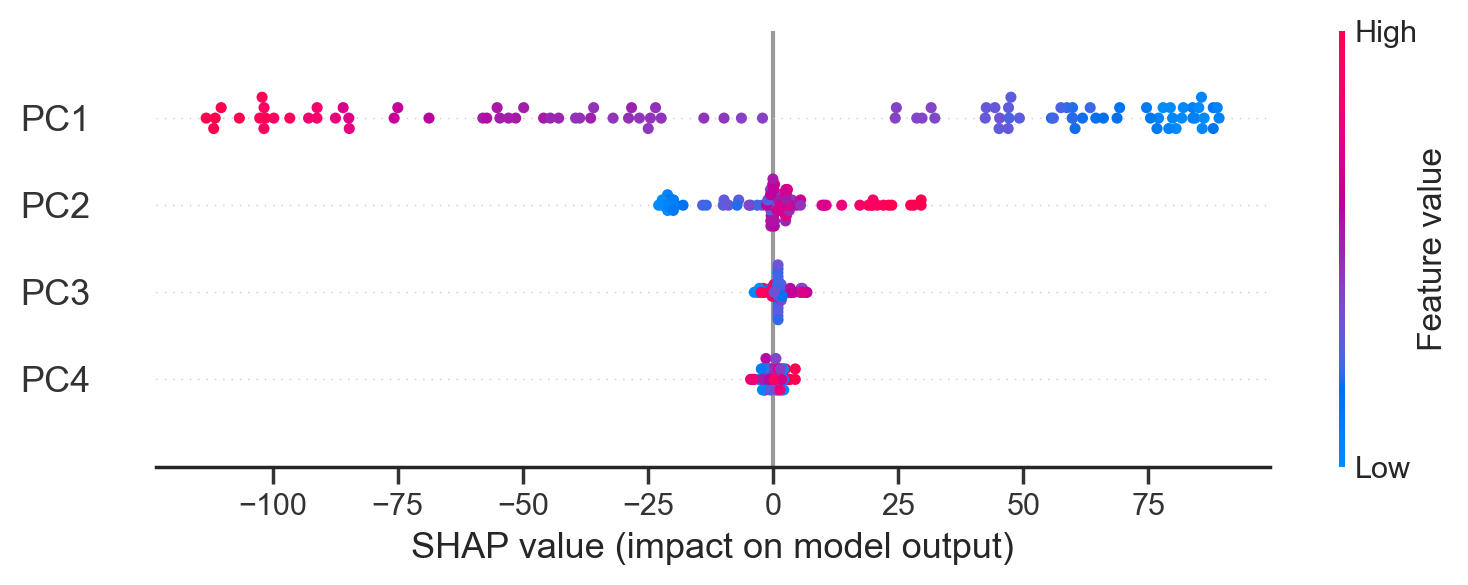

In [112]:
shap.summary_plot(shap_values, X_pca_transformed_df)


### relation with the target  

In [113]:
X_subset_PCA = X_pca_transformed_df
X_subset_PCA.shape

(100, 4)

#### correlation 

In [114]:
pca_corr_with_target = X_subset_PCA.join(y).corr()['flow_rate'].iloc[:-1]
pca_corr_with_target

PC1   -0.955278
PC2    0.119356
PC3   -0.191712
PC4    0.089735
Name: flow_rate, dtype: float64

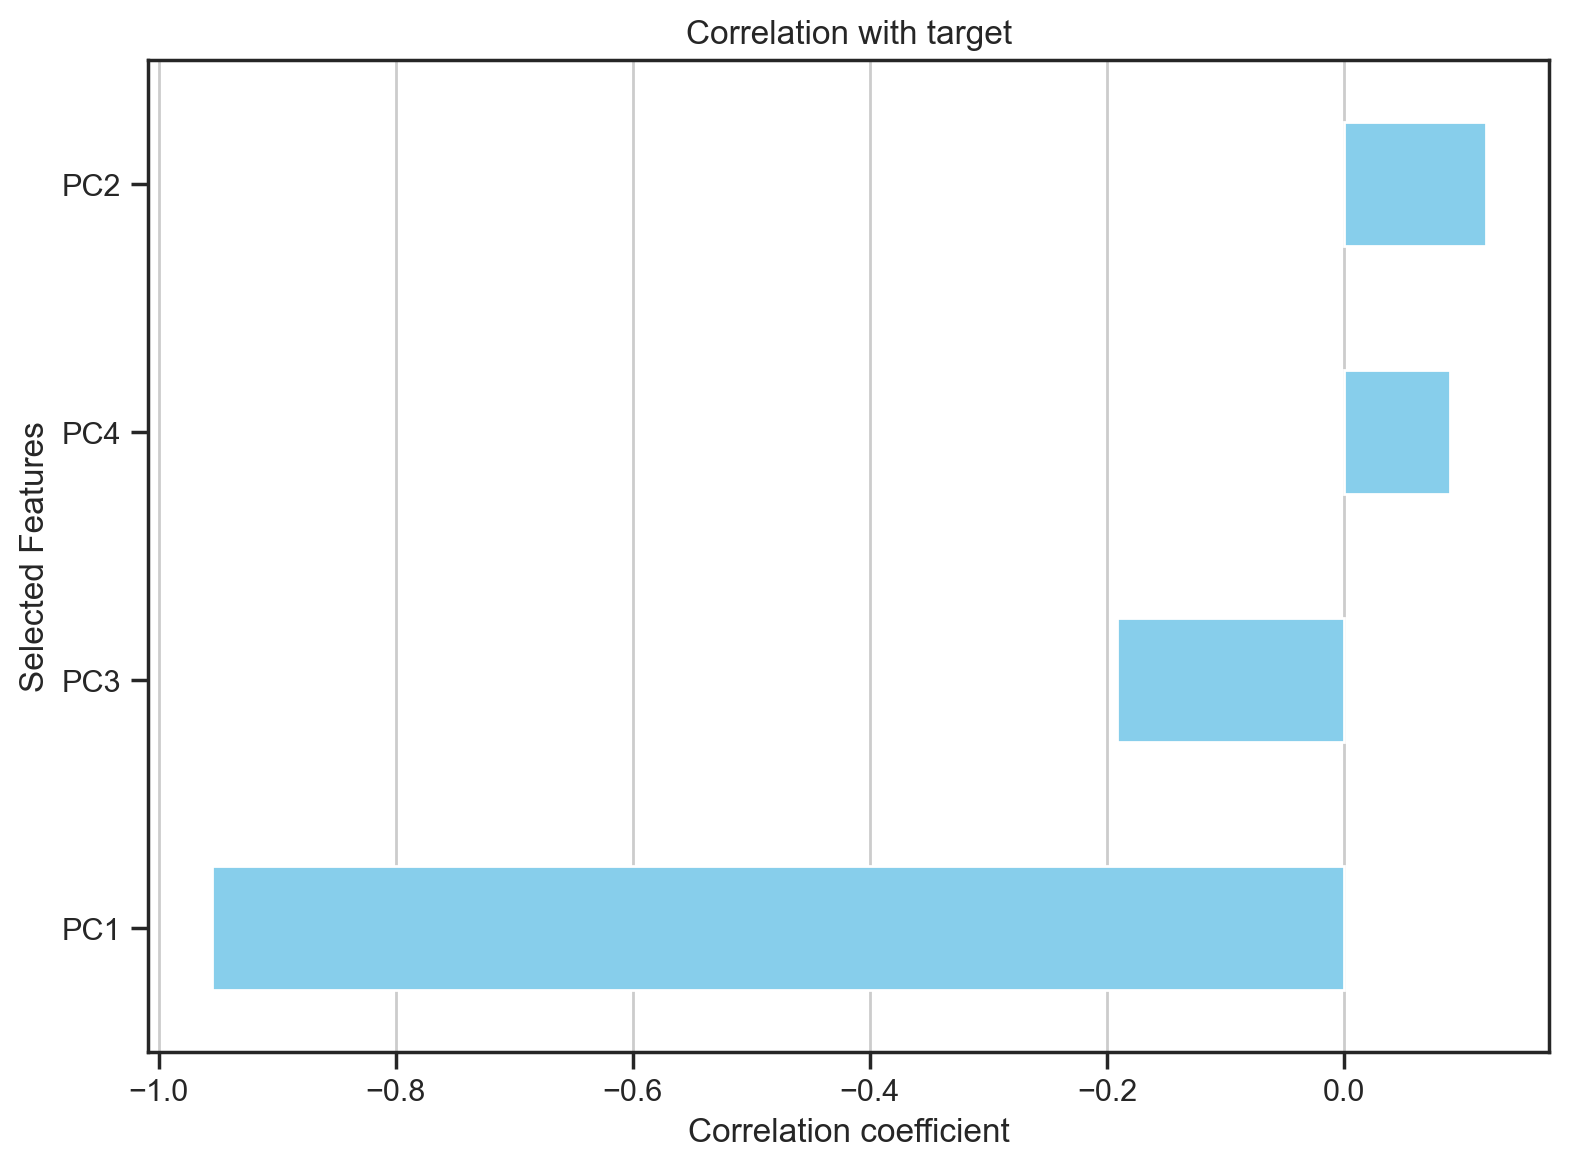

In [115]:
pca_corr_with_target.sort_values().plot(kind='barh', color='skyblue')

plt.title('Correlation with target')
plt.xlabel('Correlation coefficient')
plt.ylabel('Selected Features')
plt.grid(axis='x')

plt.tight_layout()
plt.show()

#### importance

In [117]:
rf.fit(X_subset_PCA, y)

feature_importance_selected_PCA = rf.feature_importances_

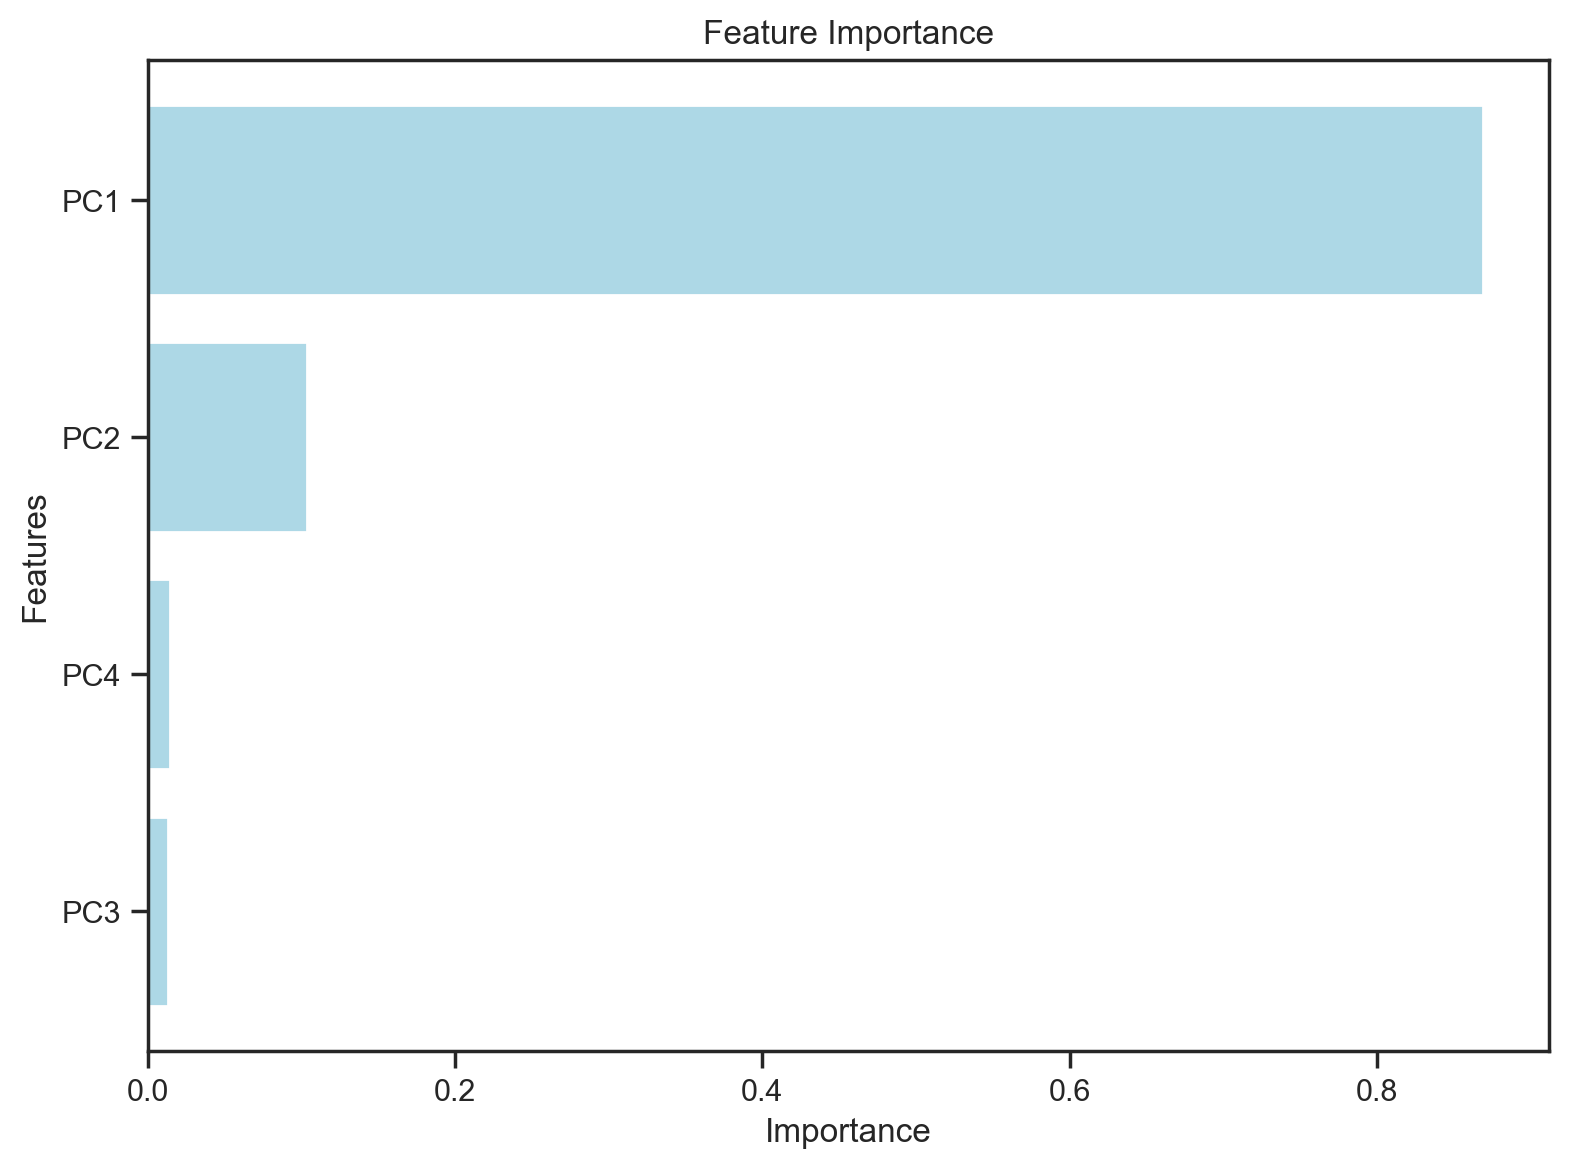

In [118]:
features_PCA = list(X_subset_PCA.columns)
feature_importance_pairs_PCA = sorted(zip(features_PCA, feature_importance_selected_PCA), key=lambda x: x[1], reverse=True)


features_sorted_PCA, importances_sorted_PCA = zip(*feature_importance_pairs_PCA)


plt.figure(figsize=(8, 6))
plt.barh(features_sorted_PCA, importances_sorted_PCA, color='lightblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

#### distribution

In [119]:
X_subset_PCA.shape

(100, 4)

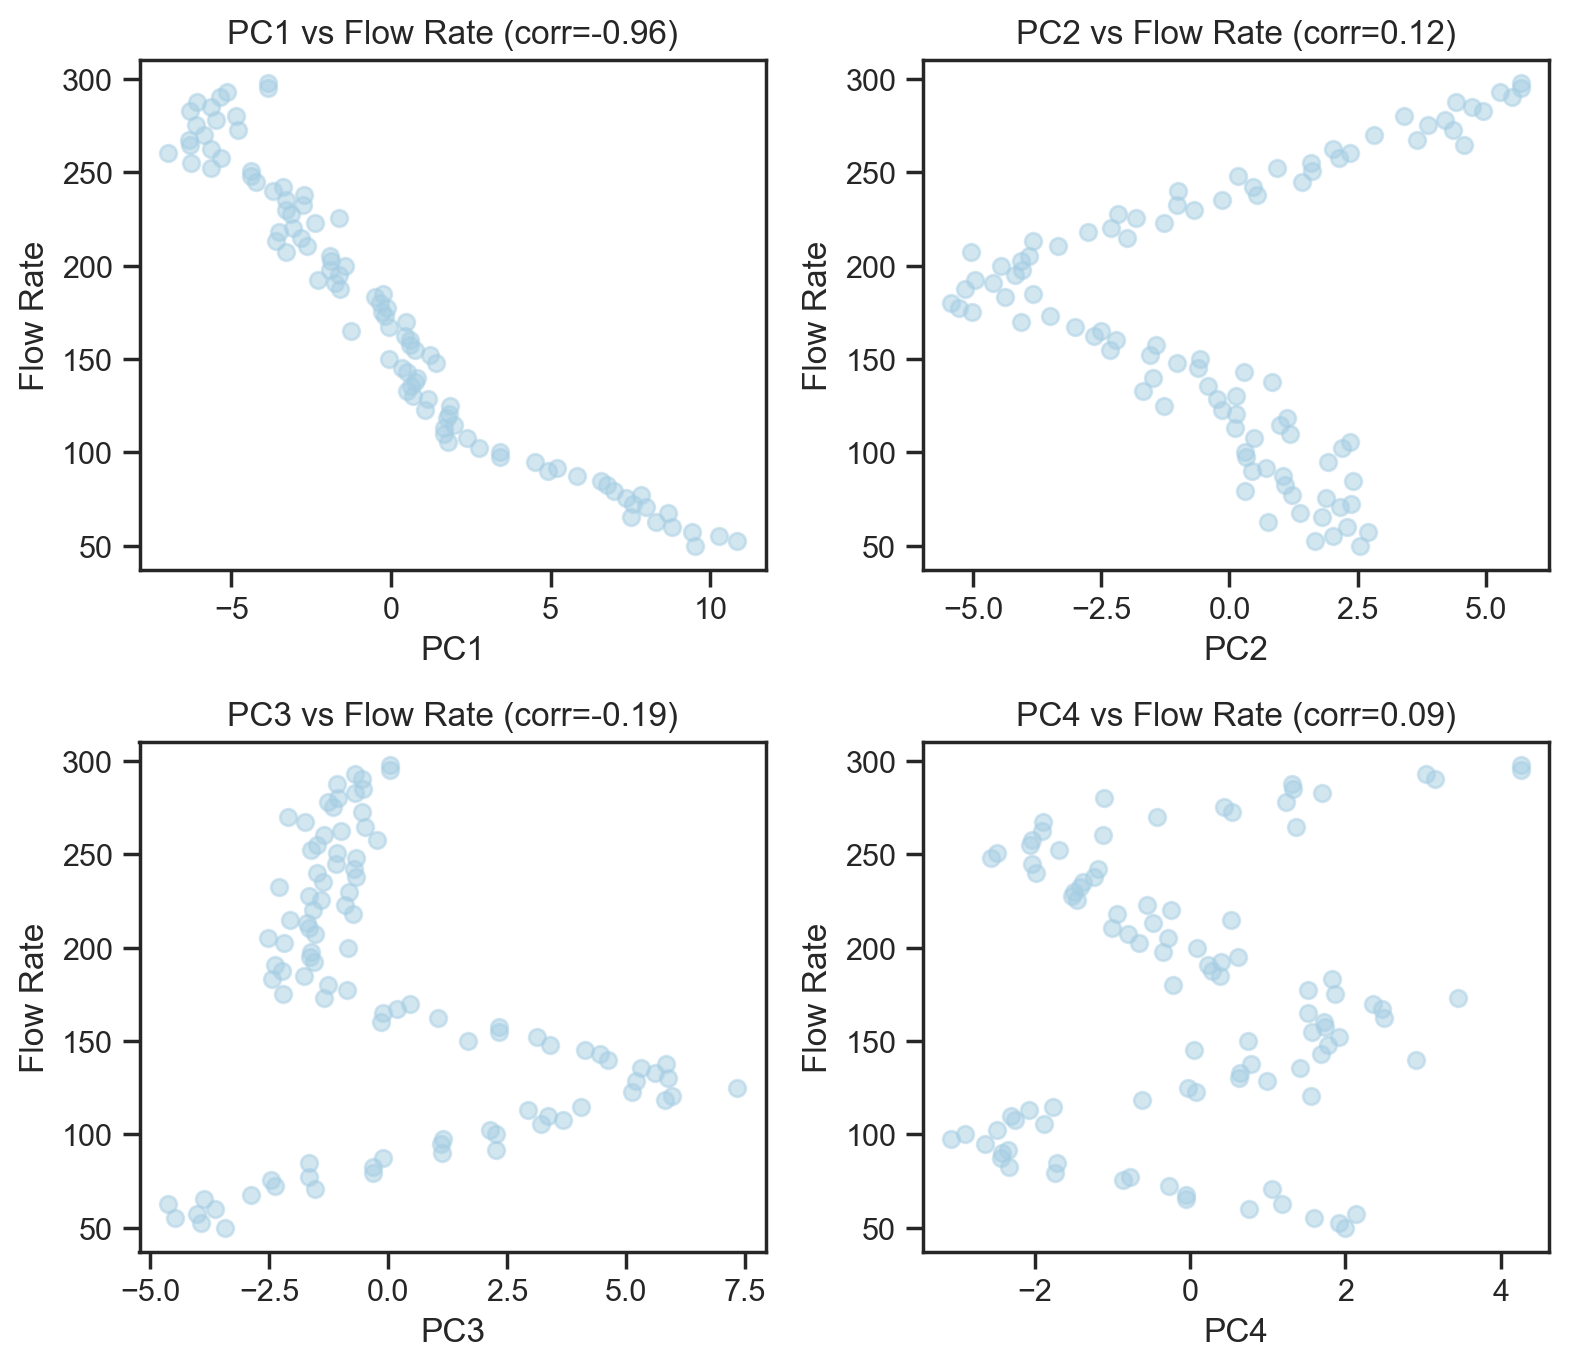

In [125]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 7))

# fig.delaxes(axes[2][1])

for idx, feature in enumerate(X_subset_PCA.columns):
    ax = axes[idx // 2, idx % 2]
    ax.scatter(X_subset_PCA[feature], y, alpha=0.5)
    ax.set_title(f'{feature} vs Flow Rate (corr={pca_corr_with_target[feature]:.2f})')
    ax.set_xlabel(feature)
    ax.set_ylabel('Flow Rate')

    
plt.tight_layout()
plt.show()

### contribution of ori. features on PCs

In [126]:
components = pd.DataFrame(pca.components_,
                          columns=X_extracted.columns,
                          index=["PC1", "PC2", "PC3", "PC4"])
components

b1_freq  b1_power   b2_freq  b2_power   b3_freq  b3_power   b4_freq  \
PC1 -0.024878 -0.107857  0.056110 -0.133593  0.167878  0.007628  0.030698   
PC2  0.000677 -0.119199 -0.015689 -0.158002 -0.024781 -0.067140  0.082129   
PC3 -0.289880  0.211907 -0.309620  0.096519  0.107599 -0.009628 -0.001016   
PC4 -0.038675 -0.111639  0.076683 -0.117165  0.016592 -0.027844  0.087196   

     b4_power   b5_freq  b5_power  ...  b28_power  b29_freq  b29_power  \
PC1  0.199218 -0.110880  0.106136  ...   0.094598 -0.040652   0.178595   
PC2  0.027340 -0.105577 -0.125769  ...   0.238706 -0.069620   0.042157   
PC3 -0.083098  0.081165 -0.126407  ...  -0.169564  0.051418  -0.179617   
PC4  0.000512  0.040685  0.207488  ...  -0.097011  0.481544   0.000057   

     b30_freq  b30_power      mean       std      skew      kurt       auc  
PC1  0.151004   0.061547  0.027670 -0.193247 -0.138550 -0.207847  0.193512  
PC2  0.038937  -0.028999  0.305599  0.091807 -0.232726 -0.040918  0.039972  
PC3 -0.016727   0.234342 -0.041147 -0.013544 -0.008276 -0.027758 -0.069164  
PC4 -0.097727  -0.076999  0.115566  0.026012  0.057570  0.075987 -0.013558  

[4 rows x 65 columns]

PC1: 0.3161
PC2: 0.1266
PC3: 0.1116
PC4: 0.0464


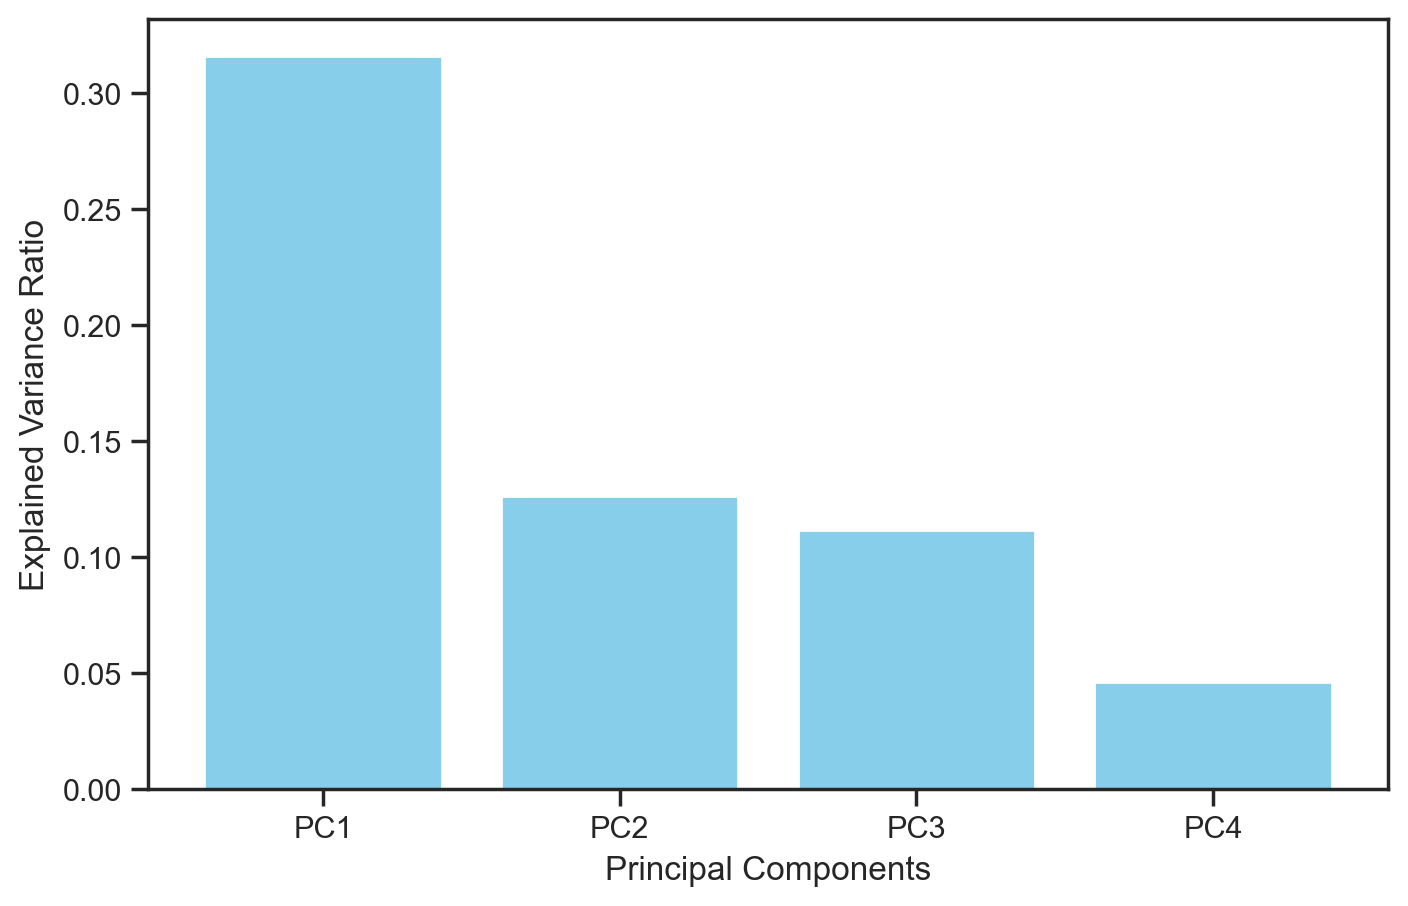

In [127]:
# 获取explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

for i, ratio in enumerate(explained_variance_ratio, 1):
    print(f"PC{i}: {ratio:.4f}")

    
plt.figure(figsize=(8, 5))
plt.bar(["PC1", "PC2", "PC3", "PC4"], explained_variance_ratio, color='skyblue')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')


plt.show()


In [128]:
explained_variance_ratio

array([0.31611276, 0.12663438, 0.11161119, 0.04644223])

In [130]:
feature_counts = {}

for feature_set in [X_subset_SFS]:
    for col in feature_set.columns:
        if col in feature_counts:
            feature_counts[col] += 1
        else:
            feature_counts[col] = 1


features_selected = list(feature_counts.keys())
counts = list(feature_counts.values())

#### PC1 vs. PC2

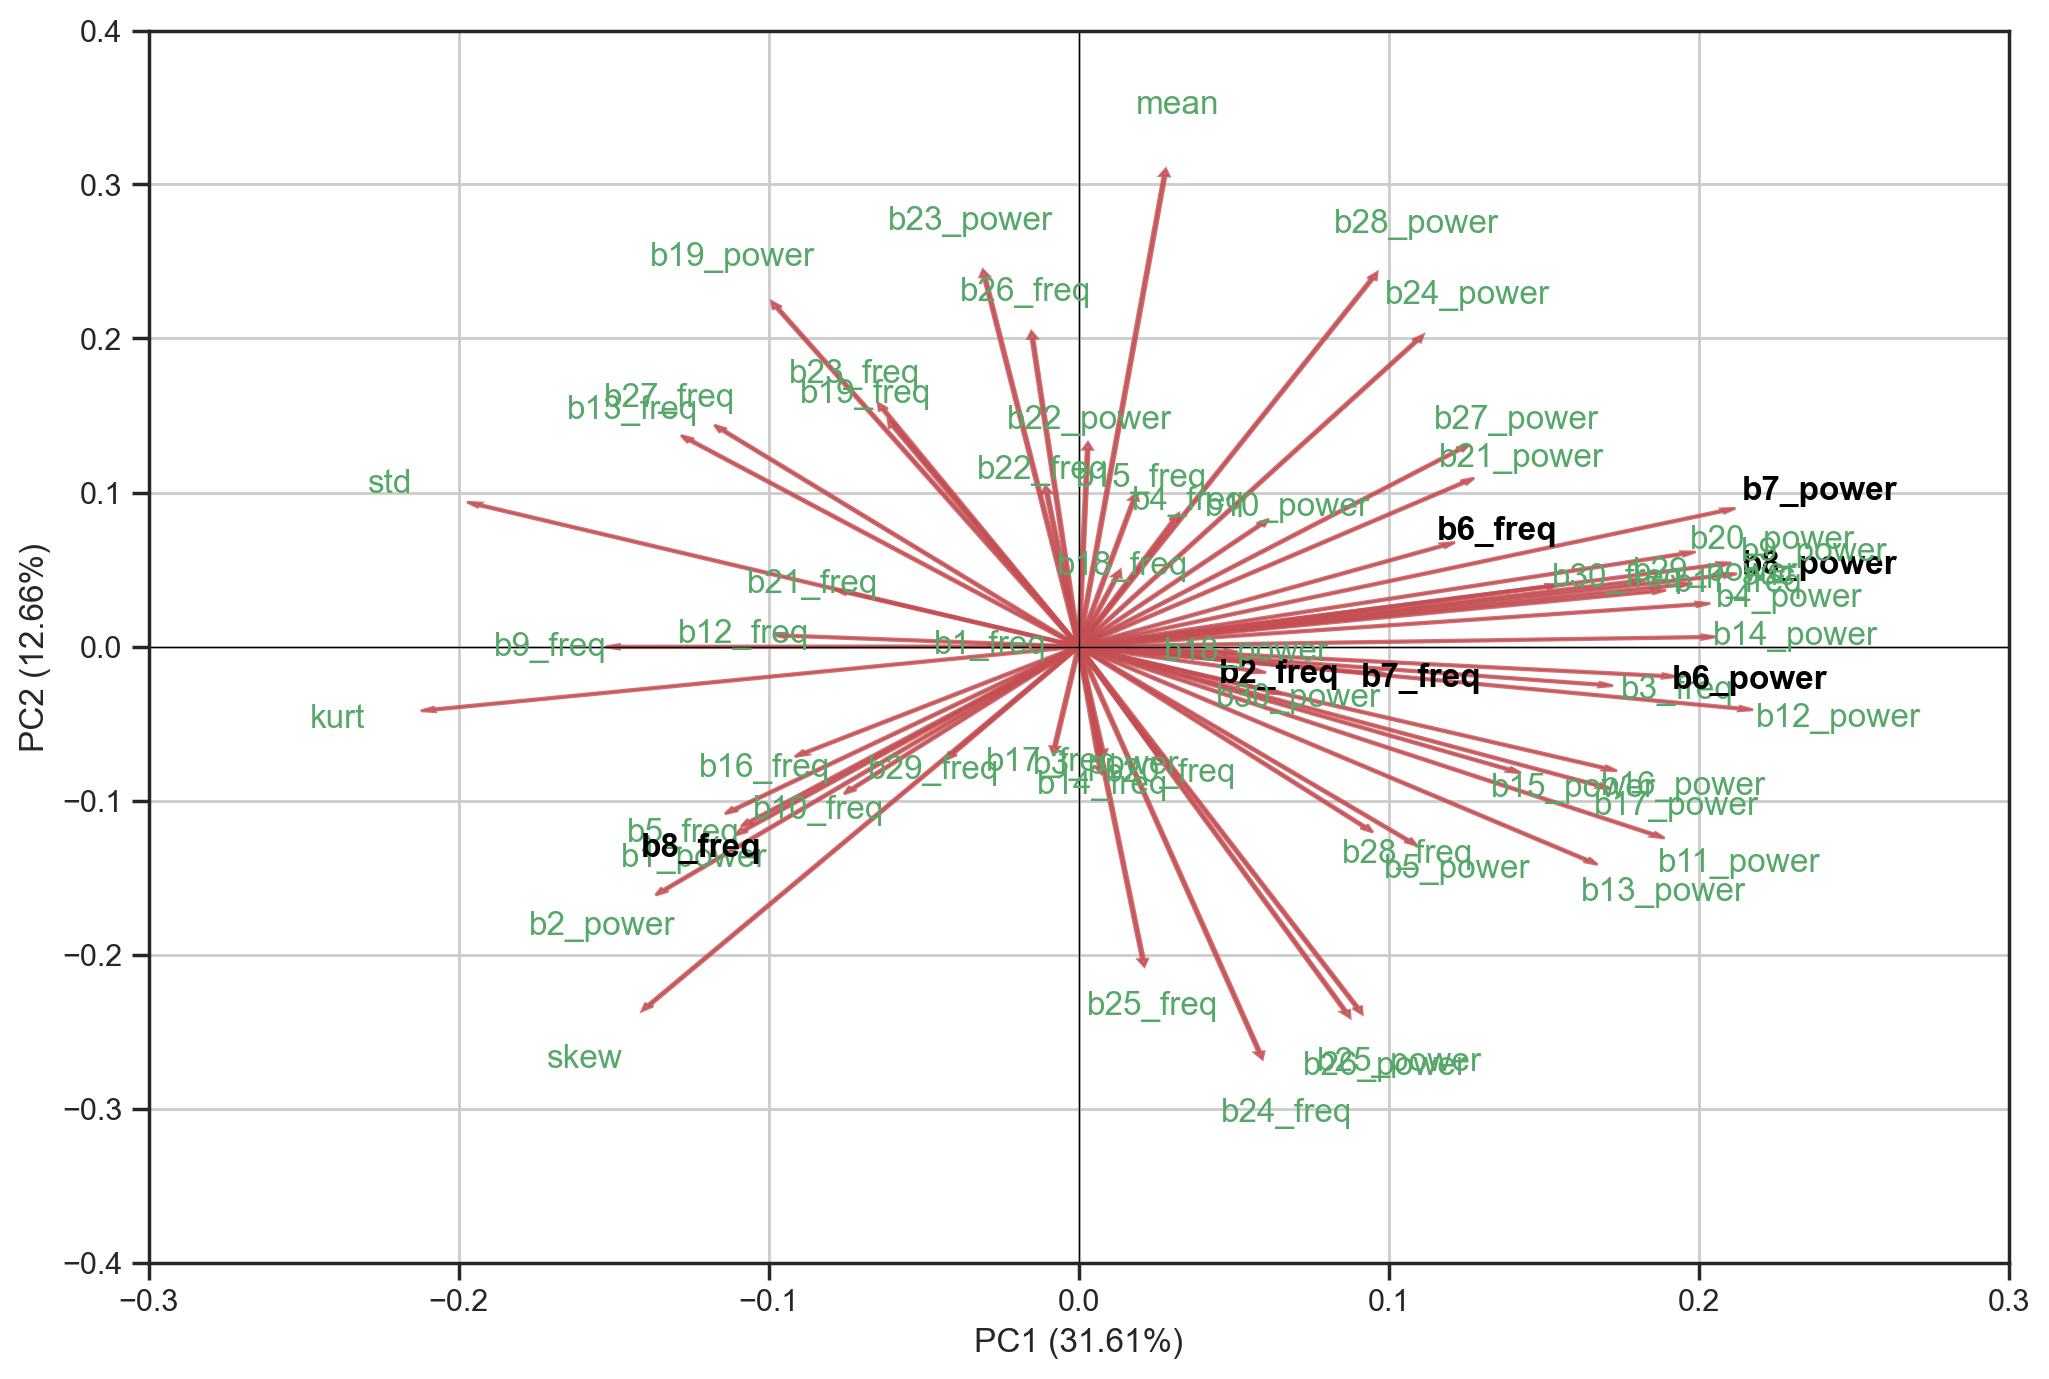

In [132]:
plt.figure(figsize=(12, 8))
    
# Retrieve the contributions of original features to pc1 and pc2.
pc1_contributions = components.loc["PC1"]
pc2_contributions = components.loc["PC2"]

# Plot each feature's contribution on the plane.
for i, feature in enumerate(components.columns):
    plt.arrow(0, 0, pc1_contributions[i], pc2_contributions[i]
              , alpha = 0.8
              , color = 'r'
             )
    if feature in features_selected:
        plt.text(pc1_contributions[i]*1.15
                 , pc2_contributions[i]*1.15
                 , feature
                 , color='black'
                 ,ha = 'center'
                 , va = 'center'
#                  , fontsize=15
                 ,fontweight='bold'
                 
            )
        
    else:    
        plt.text(pc1_contributions[i]*1.15
                 , pc2_contributions[i]*1.15
                 , feature
                 , color='g'
                 ,ha = 'center'
                 , va = 'center'
                )

plt.xlabel("PC1 (31.61%)")
plt.ylabel("PC2 (12.66%)")
plt.grid(True)
plt.axvline(0, color='black',linewidth=0.5)
plt.axhline(0, color='black',linewidth=0.5)
plt.xlim([-0.3, 0.3])
plt.ylim([-0.4, 0.4])

# plt.savefig('plots/1727/agligned_pc1vspc2.png')
plt.show()

#### PC1 vs. PC3

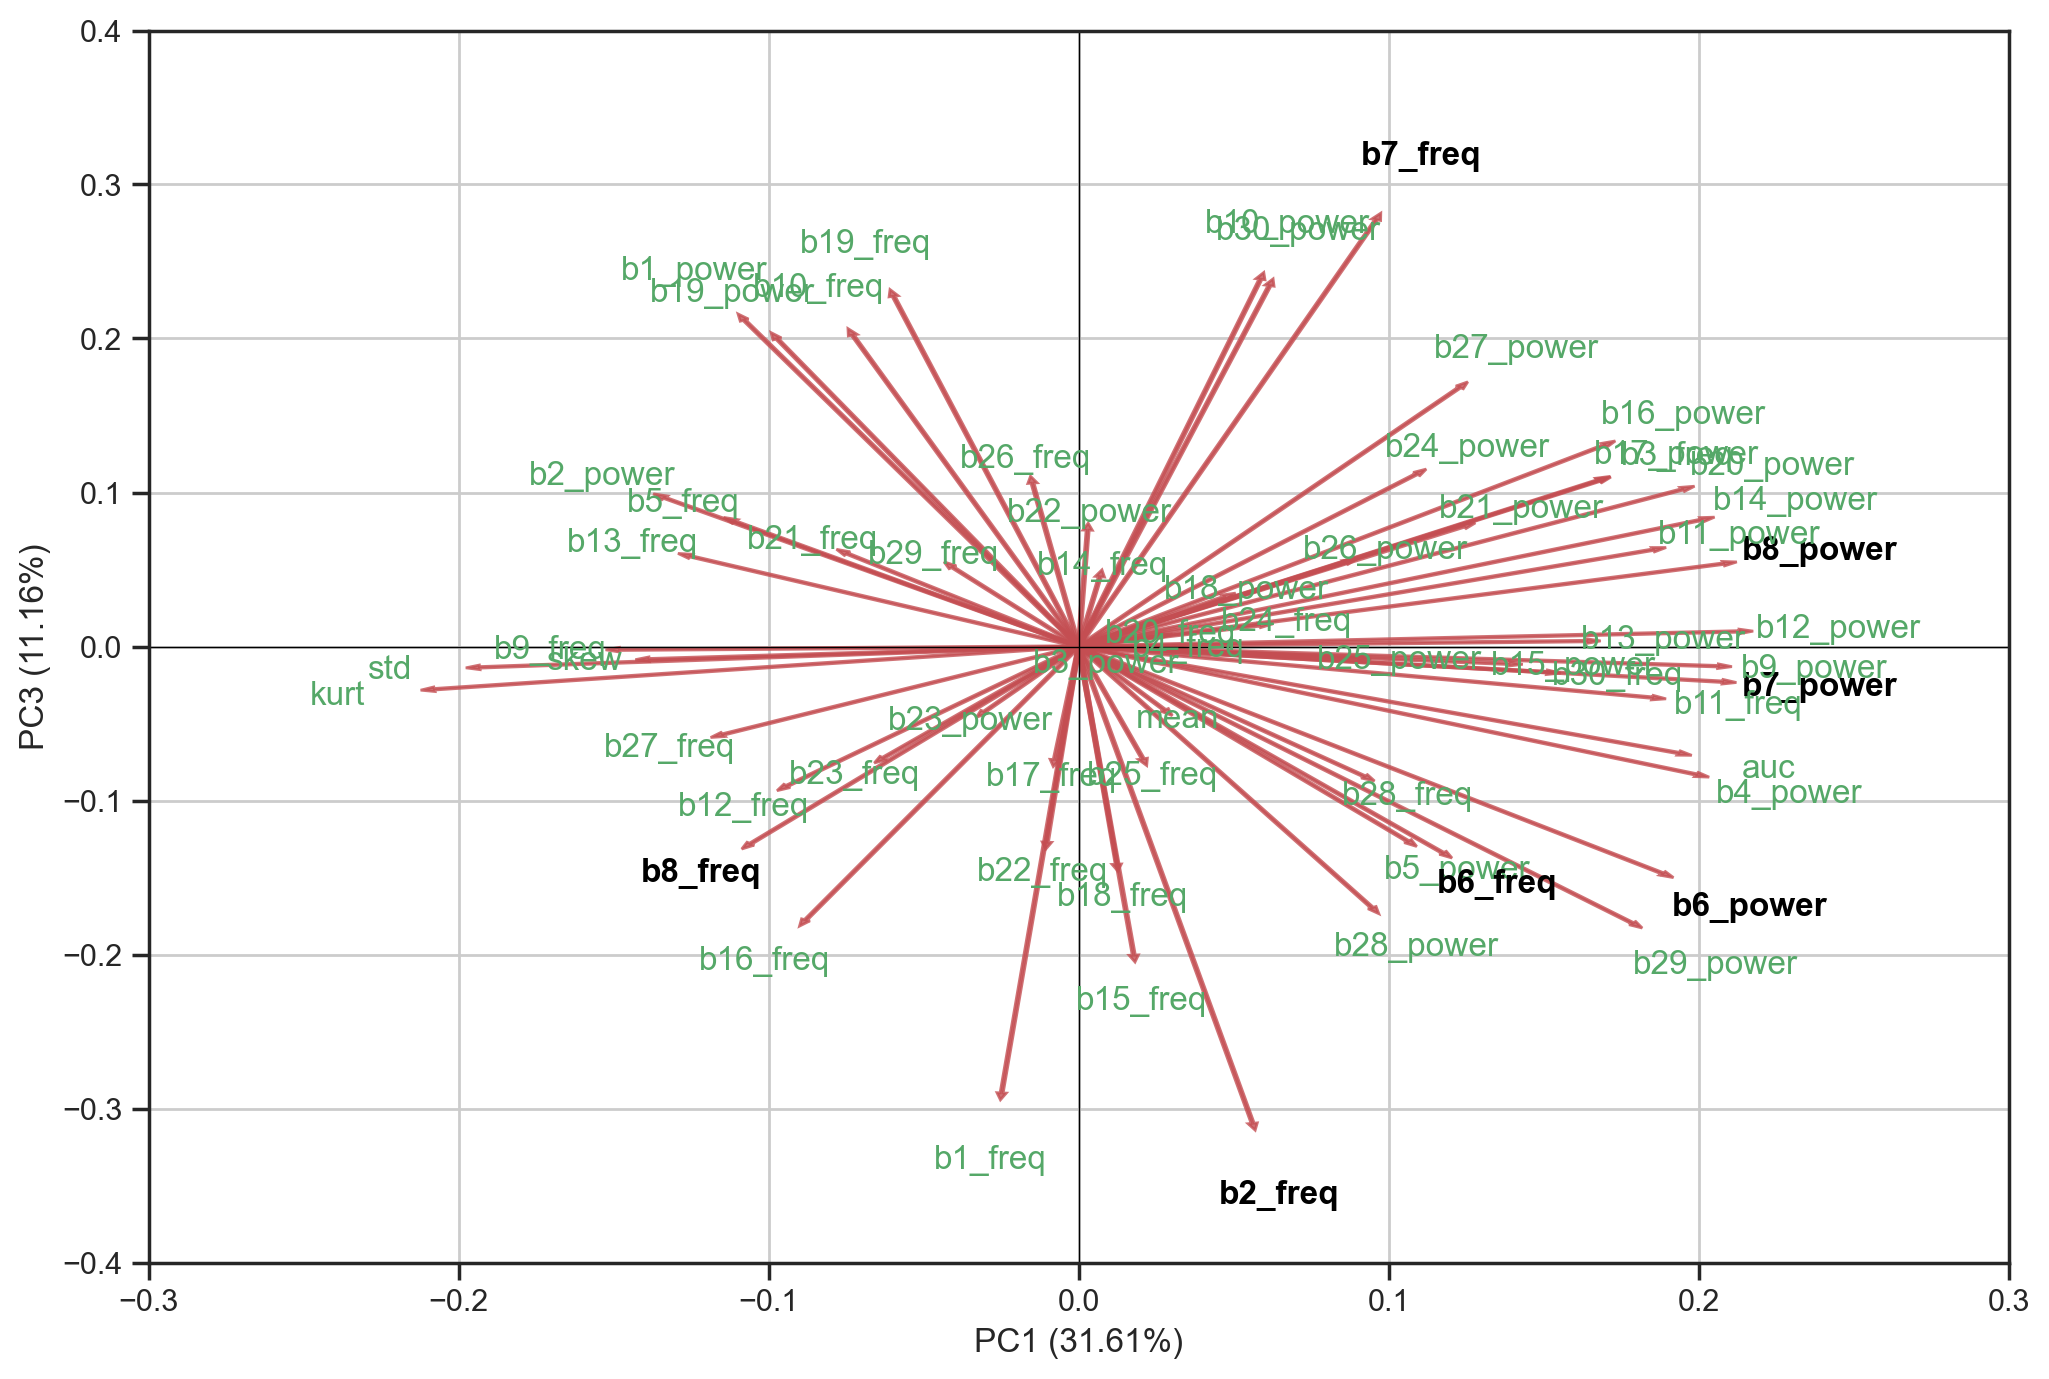

In [134]:
plt.figure(figsize=(12, 8))
    
# Retrieve the contributions of original features to pc1 and pc2.
pc1_contributions = components.loc["PC1"]
pc3_contributions = components.loc["PC3"]

# Plot each feature's contribution on the plane.
for i, feature in enumerate(components.columns):
    plt.arrow(0, 0, pc1_contributions[i], pc3_contributions[i]
              , alpha = 0.8
              , color = 'r'
             )
    
    if feature in features_selected:
        plt.text(pc1_contributions[i]*1.15
                 , pc3_contributions[i]*1.15
                 , feature
                 , color='black'
                 ,ha = 'center'
                 , va = 'center'
#                  , fontsize=15
                 ,fontweight='bold'
                 
            )
        
    else:    
        plt.text(pc1_contributions[i]*1.15
                 , pc3_contributions[i]*1.15
                 , feature
                 , color='g'
                 ,ha = 'center'
                 , va = 'center'
                )

plt.xlabel("PC1 (31.61%)")
plt.ylabel("PC3 (11.16%)")
plt.grid(True)
plt.axvline(0, color='black',linewidth=0.5)
plt.axhline(0, color='black',linewidth=0.5)
plt.xlim([-0.3, 0.3])
plt.ylim([-0.4, 0.4])


# plt.savefig('plots/1727/agligned_pc1vspc3.png')
plt.show()

#### PC2 vs. PC3

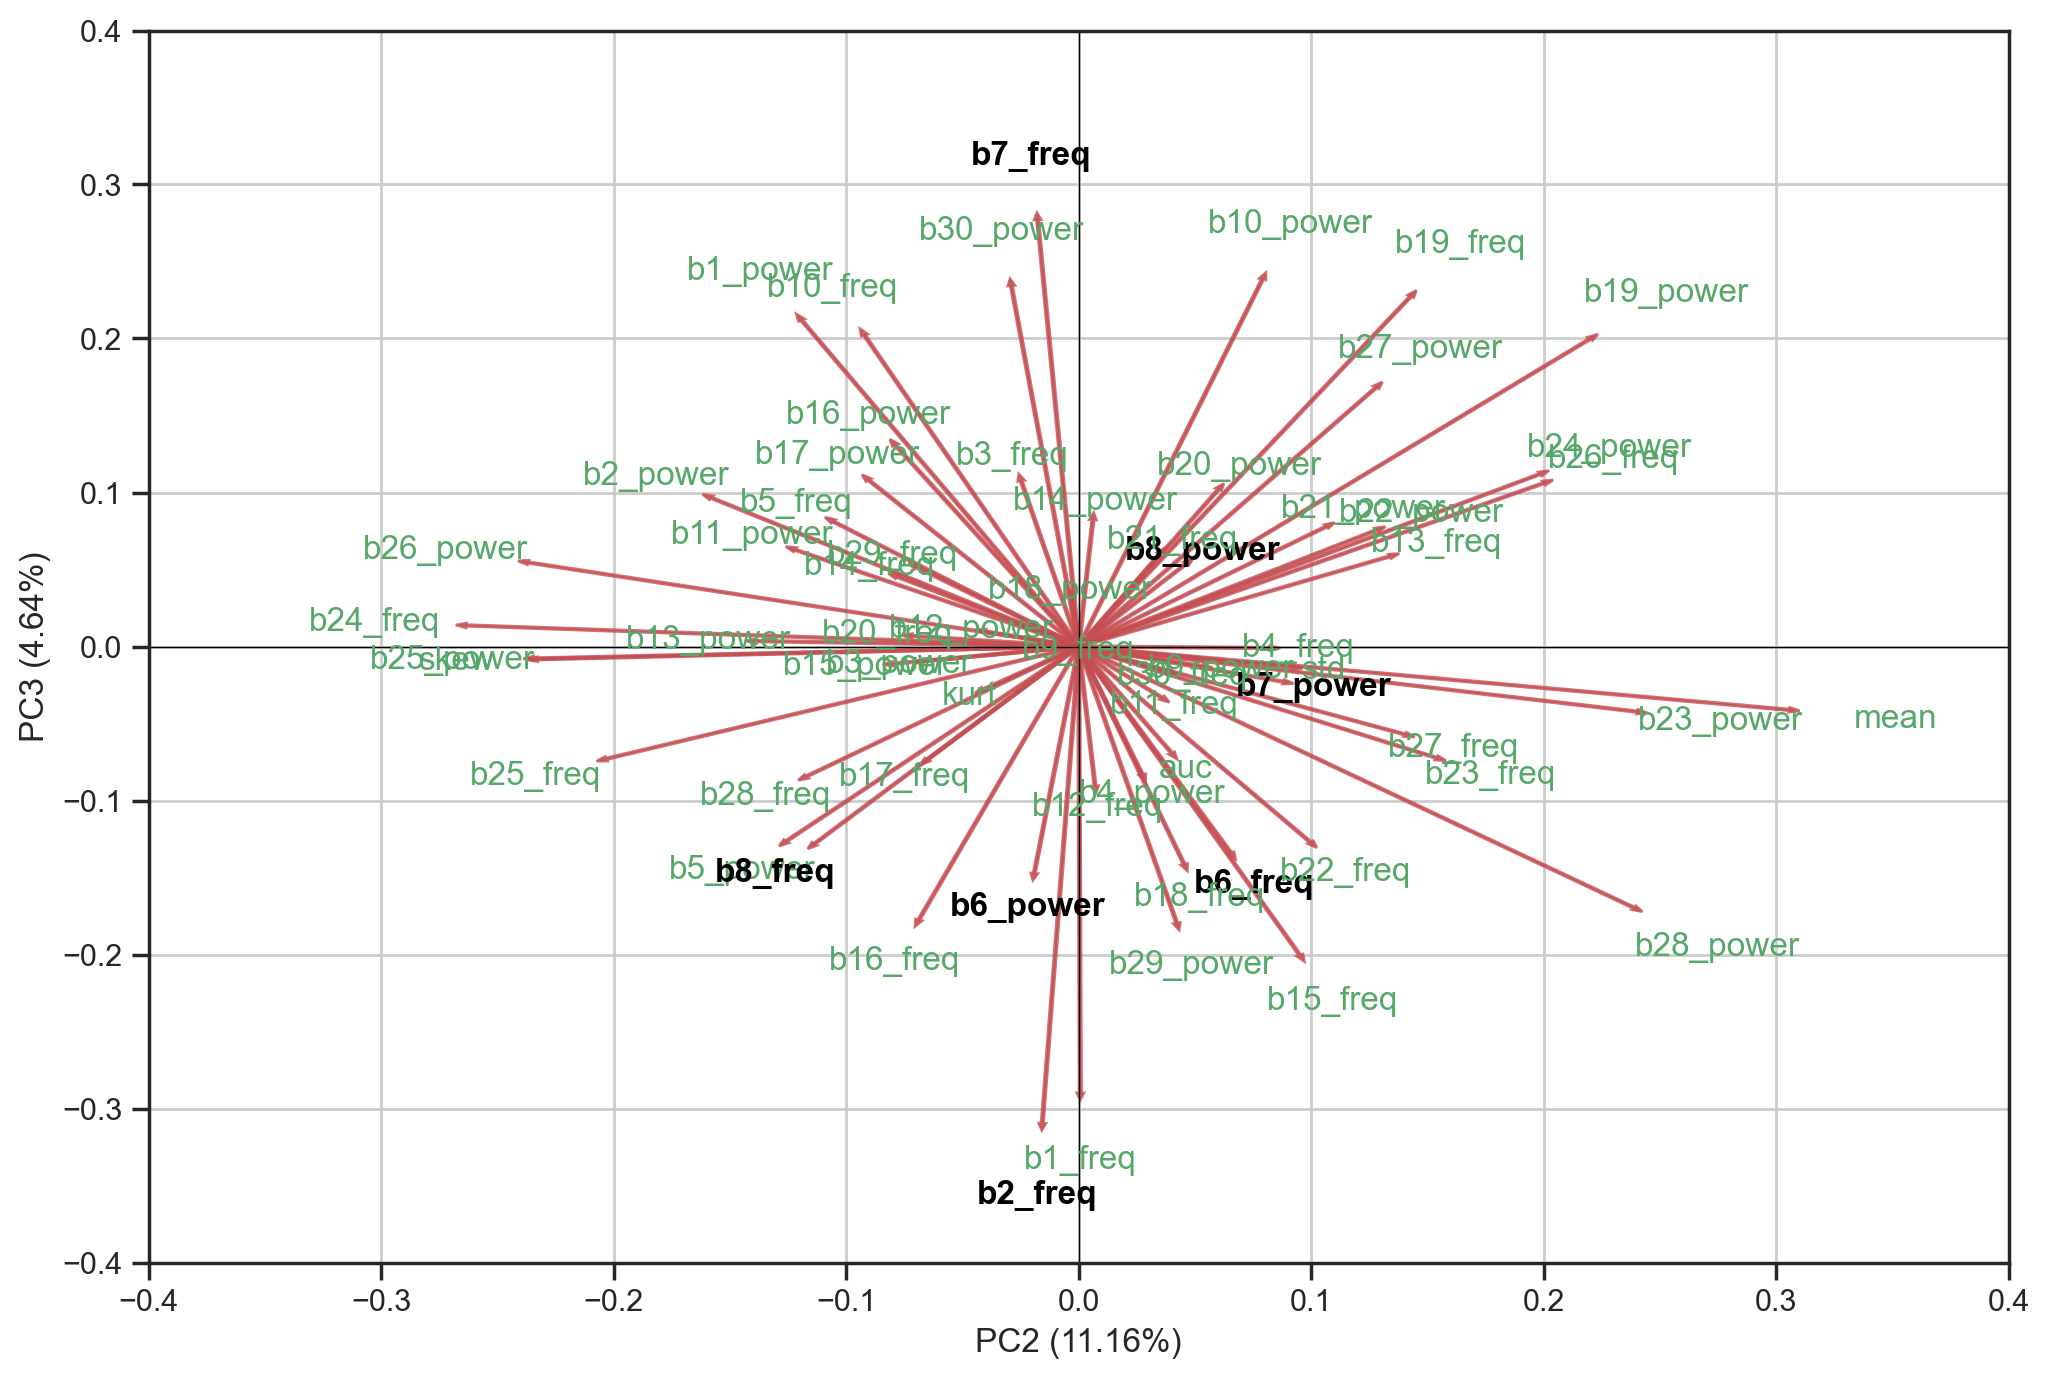

In [135]:
plt.figure(figsize=(12, 8))
    
# Retrieve the contributions of original features to pc1 and pc2.
pc2_contributions = components.loc["PC2"]
pc3_contributions = components.loc["PC3"]

# Plot each feature's contribution on the plane.
for i, feature in enumerate(components.columns):
    plt.arrow(0, 0, pc2_contributions[i], pc3_contributions[i]
              , alpha = 0.8
              , color = 'r'
             )
    if feature in features_selected:
        plt.text(pc2_contributions[i]*1.15
                 , pc3_contributions[i]*1.15
                 , feature
                 , color='black'
                 ,ha = 'center'
                 , va = 'center'
#                  , fontsize=15
                 ,fontweight='bold'
                 
            )
        
    else:    
        plt.text(pc2_contributions[i]*1.15
                 , pc3_contributions[i]*1.15
                 , feature
                 , color='g'
                 ,ha = 'center'
                 , va = 'center'
                )
    

plt.xlabel("PC2 (11.16%)")
plt.ylabel("PC3 (4.64%)")
plt.grid(True)
plt.axvline(0, color='black',linewidth=0.5)
plt.axhline(0, color='black',linewidth=0.5)
plt.xlim([-0.4, 0.4])
plt.ylim([-0.4, 0.4])



# plt.savefig('plots/1727/agligned_pc2vspc3.png')
plt.show()